#  Bulk RNA-Seq and scRNA-seq WGCNA Analysis Supplementary 

Scripts written by **Lisa Yeter Mesrop** accompanying the publication Single cell analysis reveals the molecular signaling and cellular composition of the regnerating Hydra Head Authors: Aide Macias-Muñoz, Lisa Y. Mesrop, Heidi Yahan Liang and Ali Mortazavi. 

The scripts below perform the following: 
-  Read mapping of Bulk RNA-Seq Hydra Regeneration and Hypostome (Murad and Macias-Munoz et al., 2021) with Kallisto. 
-  Count normalization with DESeq2 
-  Gene coexpression network analysis with WGCNA 
-  GO enrichment with TopGO
-  Network Visualization


In [1]:
#load libraries 
library(WGCNA)
library(tidyverse) 
library(edgeR)
library(matrixStats)
library(DESeq2)
library(dplyr)
library(data.table)
library(ggraph) 
library(graphlayouts)
library(igraph)
library(topGO)
library(readxl)


#The following setting is important for WGCNA analysis, do not omit.
options(stringsAsFactors = FALSE);
enableWGCNAThreads()
allowWGCNAThreads(nThreads = 22)

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘edgeR’ was built under R version 3.6.2”
Loading required package: limma


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required pack

Allowing parallel execution with up to 39 working processes.
Allowing multi-threading with up to 22 threads.


## 1. Read in gene-level counts using Kallisto

Bulk RNA-seq fasta files were downloaded from NCBI and were mapped back to the reference using Kallisto on POD UCSB Cluster.

In [2]:
#set working directory 
setwd('/home/lmesrop/hydra_project/wgcna_bulk_hydra/Hydra_bulk_wgcna_111221/scHydra_project_github')


In [ ]:
#downloaded mapped counts to my working directory and checked to make sure the path is correct 
all(file.exists(path)) #must say TRUE


#read in the gene names
merged <- read.delim("/Users/lisamesrop/Desktop/Hydra_single_cell/bulk_RNA_seq_analysis/merged.txt", header=FALSE)
merged_v2<- merged %>% separate( V1, into = c("cut"), sep=".t(.*)")


#rename the columns  
names(merged_v2)[1] <- "target_id"
names(merged_v2)[2] <- "gene_name"

merged_v3 <- merged_v2[c("gene_name", "target_id")]

#retrieve the count matrix
Txi_gene <- tximport(path, 
                     type = "kallisto", 
                     tx2gene = merged_v3, #transcript-to-gene mapping file 
                     txOut = FALSE) 
                    

myTPM <- Txi_gene$abundance #transcript per million measurement 
mycounts <- Txi_gene$counts #raw number of reads mapped to that gene in that sample 
colSums(myTPM)
colSums(mycounts)

#get quick stats 
mycounts.stats <- transform(mycounts, SD=rowSds(mycounts), AVG=rowMeans(mycounts), MED=rowMedians(mycounts))
head(mycounts)

#make a ggplot from the quick stats 
ggplot(mycounts.stats) + aes(x=SD, y=MED) + geom_point(shape=16, size=2)

#meta data needed for DESeq2 anlaysis 

#need to add the sample names back to mycounts table 
colnames(mycounts) <- c(sampleLabels)

#need to make a meta object 
meta <- data.frame(row.names = colnames(mycounts))
sample_names <- c("Reg_RNA_0hr", "Reg_RNA_0hr", "Reg_RNA_2hr", "Reg_RNA_2hr", "Reg_RNA_4hr", "Reg_RNA_4hr", "Reg_RNA_6hr", 
                  "Reg_RNA_6hr", "Reg_RNA_12hr", "Reg_RNA_12hr", "Reg_RNA_24hr", "Reg_RNA_24hr", "Reg_RNA_48hr", "Reg_RNA_48hr", 
                  "Hypostome", "Hypostome")

meta$sample_names <- sample_names
meta$names <- rownames(meta)
rownames(meta) <- NULL



## 2. Filter and normalize gene count matrix using DESeq2

In [ ]:
#rename mycounts to dds_count_table 
dds_count_table <- mycounts

In [5]:
#check the number of genes
nrow(dds_count_table); #33820


[1] 33820

In [35]:
#filter the count table 
dds_count_table_prefiltered <- dds_count_table[rowSums(counts(dds_count_table) >=10) >=2, ];
nrow(dds_count_table_prefiltered); 

[1] 16971

In [4]:
#save genes of interest into my_genes_AB object. This list of genes will be used downstream to determine which modules contain them.   
My_genes_AB<-c("Sc4wPfr-789.g22423-neuroblast-differentiationassociated-AHNAK","MSTRG.22204-neuroblast-differentiationassociated-AHNAK",
               "Sc4wPfr-227.g25773-ANTA-HYDVU-ame:-Full=Antistasin-Short=ATS-ame:-Full=Blood-coagulation-factor-Xa-proclotting-enzyme-inhibitor-Flags:-Precursor",
               "Sc4wPfr-1357.1.g3222-Homeobox-ARX", "Sc4wPfr-654.g18227-aristalessrelated-homeobox-like",
               "Sc4wPfr-177.g9412-betacatenin-1","Sc4wPfr-547.1.g24952-brachyury-isoform-X2","Sc4wPfr-489.2.g16698-brachyury-isoform-X3",
               "Sc4wPfr-17.g15881-COUP-transcription-factor-2-isoform-X2","Sc4wPfr-134.g20117-dickkopf-Dlp2-precursor","Sc4wPfr-624.g29781-segment-polarity-dishevelled-homolog-DVL3like",
               "MSTRG.3248-ELAV-2","Sc4wPfr-1309.1.g9692-ELAV-3-isoform-X1","Sc4wPfr-1241.g21489-homeobox-extradenticle-isoform-X3",
               "Sc4wPfr-677.g23720-protooncogene-cFoslike-isoform-X1","Sc4wPfr-66.g19023-RNA-binding-fox1-homolog-3like-isoform-X2",
               "Sc4wPfr-381.1.g32304-Forkhead-box","Sc4wPfr-441.g7675-Forkhead-box-K1","Sc4wPfr-909.g33493-forkhead-box-Olike","Sc4wPfr-396.g3075-forkhead-box",
               "Sc4wPfr-802.g11765-homeobox-goosecoid",
               "Sc4wPfr-635.g14708-Hym355-preprohormone","Sc4wPfr-119.1.g1450-transcription-factor-junDlike",
               "Sc4wPfr-661.g19812-KS1-HYDVU-ame:-Full=KS1-ame:-Full=Headspecific-1-ame:-Full=Kopfspezifisches-1-Flags:-Precursor","MSTRG.21513-KS1-like",
               "Sc4wPfr-844.g33330-KVamide-preprohormone-type-2","Sc4wPfr-412.g24329-LWamide-neuropeptide-precursor","Sc4wPfr-305.g4616-homeobox-Meis1like-isoform-X2",
               "Sc4wPfr-259.g33627-myb-transcription-factor","Sc4wPfr-504.g10368-myb-D","Sc4wPfr-546.1.g5178-myb-X","Sc4wPfr-717.g8768-homeobox-Nkx",
               "MSTRG.8233-homeobox-OTX1like", "MSTRG.23836-homeobox-OTX2like","MSTRG.8274-homeobox-OTX2like",
               "MSTRG.21936-Pax", "Sc4wPfr-251.g2461-transcription-factor-PaxA", "Sc4wPfr-439.g20916-Paired-box-Pax","Sc4wPfr-691.g31399-eyegone-isoform",
               "Sc4wPfr-569.1.g4046-polRFamide-neuropeptides","Sc4wPfr-884.g31959-PPOD1-peroxidase","Sc4wPfr-597.2.g14333-piwi-1-isoform-X1",
               "Sc4wPfr-224.1.g33422-transcription-factor-Sp5","Sc4wPfr-351.g11299-transcription-factor-SOX12like","MSTRG.13573-transcription-factor-Sox3like",
               "Sc4wPfr-1384.g16120-transcription-factor-SOX30","Sc4wPfr-347.g19261-Transcription-factor-Sox14","Sc4wPfr-372.g28037-transcription-factor-SOX17",
               "Sc4wPfr-6.g19151-Transcription-factor-Sox","Sc4wPfr-362.g23666-Transcription-factor-Sox2","Sc4wPfr-804.g24094-protooncogene-Wnt1",
               "Sc4wPfr-399.g28064-protooncogene-Wnt3","Sc4wPfr-287.2.g28262-Wnt5a-isoform-X2","Sc4wPfr-1214.g29750-Wnt2b","Sc4wPfr-440.g6790-Wnt7b-isoform-X4",
               "Sc4wPfr-68.g2322-Wnt4","Sc4wPfr-224.1.g33373-Wnt2-isoform-X2","Sc4wPfr-243.g15582-secreted-signaling-factor-Wnt11","Sc4wPfr-275.3.g1992-Wnt4","Sc4wPfr-1061.g18842-wntless-homolog",
               "Sc4wPfr-861.g31120-vasa", "Sc4wPfr-6.g19151-sox-18", "Sc4wPfr-372.g28037-sox-17", "Sc4wPfr-1384.g16120-sox13-like", "Sc4wPfr-226.1.g26815-regulatory-gene")


In [5]:
#remove the annotated names and have the transcript IDs match the transcript IDs in the count table 
my_genes_df <- as.data.frame(My_genes_AB)

In [6]:
head(my_genes_df)

,My_genes_AB
,<chr>
1,Sc4wPfr-789.g22423-neuroblast-differentiationassociated-AHNAK
2,MSTRG.22204-neuroblast-differentiationassociated-AHNAK
3,Sc4wPfr-227.g25773-ANTA-HYDVU-ame:-Full=Antistasin-Short=ATS-ame:-Full=Blood-coagulation-factor-Xa-proclotting-enzyme-inhibitor-Flags:-Precursor
4,Sc4wPfr-1357.1.g3222-Homeobox-ARX
5,Sc4wPfr-654.g18227-aristalessrelated-homeobox-like
6,Sc4wPfr-177.g9412-betacatenin-1


In [104]:

my_genes_df_split <- my_genes_df %>% separate(My_genes_AB, c("col1", "col2"), "-")

Warning message:
“Expected 2 pieces. Additional pieces discarded in 64 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [105]:
head(my_genes_df_split)

,col1,col2
,<chr>,<chr>
1,Sc4wPfr,789.g22423
2,MSTRG.22204,neuroblast
3,Sc4wPfr,227.g25773
4,Sc4wPfr,1357.1.g3222
5,Sc4wPfr,654.g18227
6,Sc4wPfr,177.g9412


In [106]:
my_genes_df_split$combined <- str_c(my_genes_df_split$col1, "_", my_genes_df_split$col2)

In [107]:
head(my_genes_df_split)

,col1,col2,combined
,<chr>,<chr>,<chr>
1,Sc4wPfr,789.g22423,Sc4wPfr_789.g22423
2,MSTRG.22204,neuroblast,MSTRG.22204_neuroblast
3,Sc4wPfr,227.g25773,Sc4wPfr_227.g25773
4,Sc4wPfr,1357.1.g3222,Sc4wPfr_1357.1.g3222
5,Sc4wPfr,654.g18227,Sc4wPfr_654.g18227
6,Sc4wPfr,177.g9412,Sc4wPfr_177.g9412


In [108]:
my_genes_df_v1 <- subset(my_genes_df_split, select = -c(col1, col2))

In [109]:
head(my_genes_df_v1)

,combined
,<chr>
1,Sc4wPfr_789.g22423
2,MSTRG.22204_neuroblast
3,Sc4wPfr_227.g25773
4,Sc4wPfr_1357.1.g3222
5,Sc4wPfr_654.g18227
6,Sc4wPfr_177.g9412


In [110]:
check <- as.data.frame(rownames(dds_count_table_prefiltered))
check$names <- check$'rownames(dds_count_table_prefiltered)'
my_genes_df_v1$combined[!my_genes_df_v1$combined %in% check$names]



[1] "MSTRG.22204_neuroblast"    "MSTRG.3248_ELAV"          
[3] "MSTRG.21513_KS1"           "MSTRG.8233_homeobox"      
[5] "MSTRG.23836_homeobox"      "MSTRG.8274_homeobox"      
[7] "MSTRG.21936_Pax"           "MSTRG.13573_transcription"

In [37]:
#perform the DESeq2 normalization on the prefiltered count table. This is required before WGCNA analysis. 
dds_prefiltered <- DESeq(dds_count_table_prefiltered, betaPrior = FALSE, parallel = TRUE)
#perform a variance-stabilizing transformation
vsd_prefiltered <- getVarianceStabilizedData(dds_prefiltered)


# transpose the matrix 
datExpr <- t(vsd_prefiltered) 
## check rows/cols
nrow(datExpr)
ncol(datExpr)


estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 38 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 38 workers



[1] 16

[1] 16971

## 3. Perform WGCNA 

In [38]:
#choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to=20, by=2))
# call the network topology analysis function
sft = pickSoftThreshold(datExpr, powerVector = powers, verbose = 5)


pickSoftThreshold: will use block size 2636.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2636 of 16971
   ..working on genes 2637 through 5272 of 16971
   ..working on genes 5273 through 7908 of 16971
   ..working on genes 7909 through 10544 of 16971
   ..working on genes 10545 through 13180 of 16971
   ..working on genes 13181 through 15816 of 16971
   ..working on genes 15817 through 16971 of 16971
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.3770  1.510          0.856  5650.0   5640.00   8500
2      2   0.0404 -0.185          0.759  2720.0   2580.00   5480
3      3   0.5050 -0.705          0.820  1550.0   1360.00   3920
4      4   0.6690 -0.951          0.850   976.0    784.00   2980
5      5   0.7170 -1.100          0.856   657.0    482.00   2340
6      6   0.7410 -1.200          0.866   465.0    310.00   1900
7      7   0.7630 -1.260          0.882   341.0    205.00   1570
8      8   0.7730 -1.31

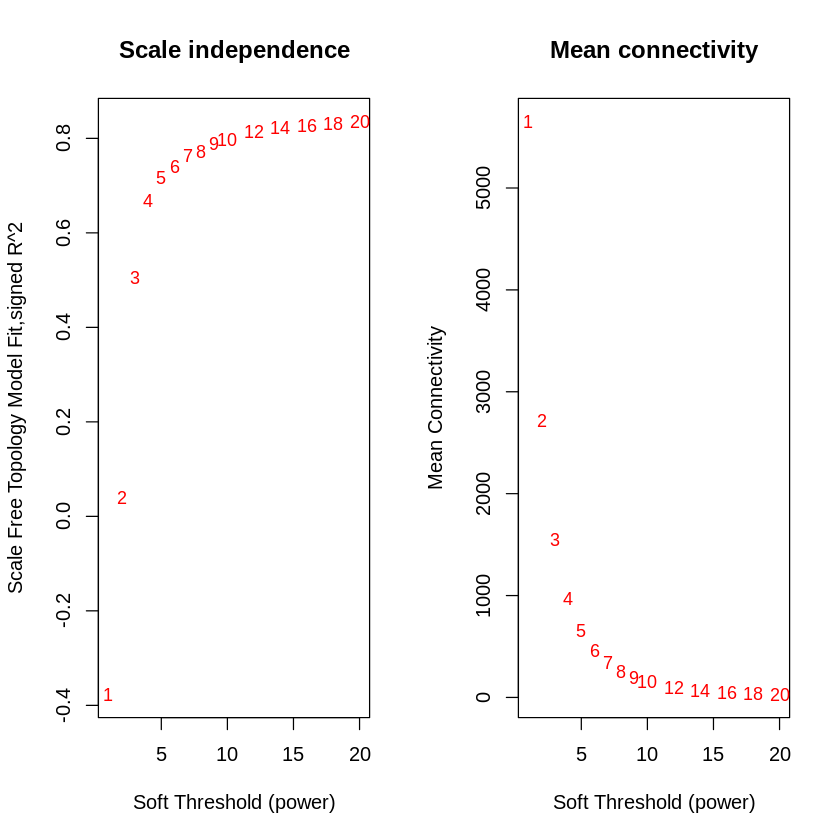

In [39]:
#plot the results:
#sizeGrWindow(9, 5)
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red")
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")


In [40]:
#co-expression similarity and adjacency using assigned softpower
softPower=18
adjacency = adjacency(datExpr, power = softPower)
#save(softPower, adjacency, file = "adjacency_signed_power18_prefiltered_10_112321.RData")


In [41]:
#topological Overlap Matrix (TOM)
#turn adjacency into topological overlap
TOM = TOMsimilarity(adjacency, TOMType = "signed", verbose = 5);
dissTOM = 1-TOM;
#save(TOM, dissTOM, file = "TOMsimilarity_signed_power18_prefiltered_10_112321.RData")


..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [42]:
## generate a clustered gene tree
geneTree <- hclust(as.dist(dissTOM), method="average")



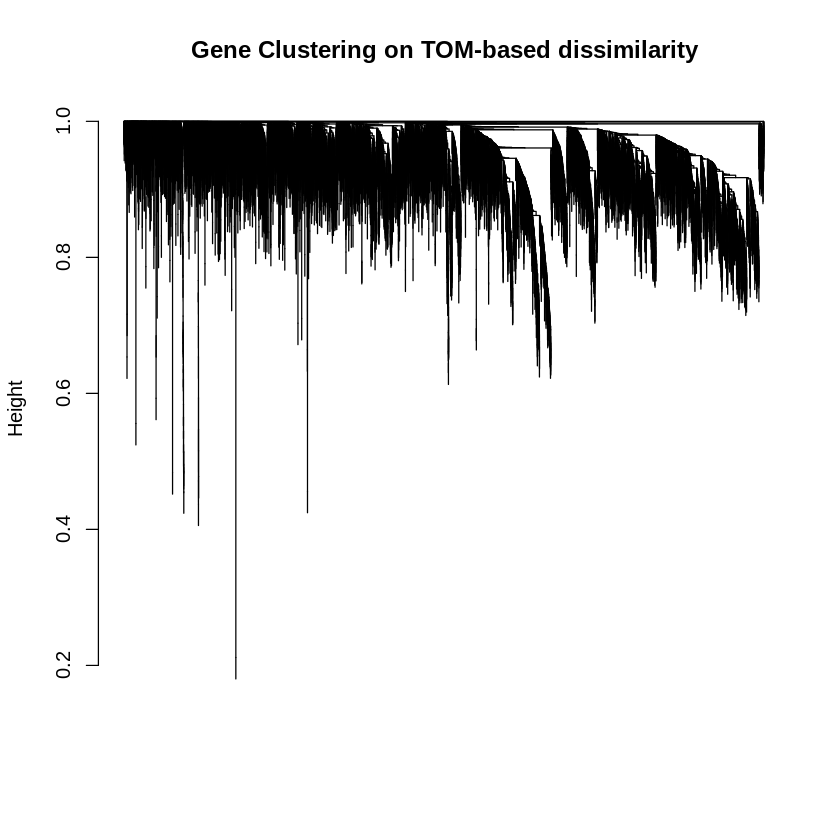

In [43]:
plot(geneTree, xlab = "", sub = "", main = "Gene Clustering on TOM-based dissimilarity",
     labels = FALSE, hang = 0.04)


In [63]:
# This sets the minimum number of genes to cluster into a module
minModuleSize <- 30
# Generate modules and assign them colors. Module identification using dynamic tree cut. 
dynamicMods <- cutreeDynamic(dendro = geneTree, distM = dissTOM , 
                             deepSplit = 3, pamRespectsDendro = FALSE, 
                             minClusterSize = minModuleSize)


 ..cutHeight not given, setting it to 0.998  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [64]:
table(dynamicMods)

# Convert numeric lables into colors
dynamicColors <- labels2colors(dynamicMods)
table(dynamicColors) 


dynamicMods
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
1835  996  681  589  491  399  389  347  346  329  325  271  265  262  248  244 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 230  226  220  215  212  198  187  186  175  156  154  153  150  148  148  148 
  32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47 
 143  140  139  137  135  131  130  123  122  122  122  117  116  114  110  109 
  48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63 
 105  105  104  101   99   98   95   94   93   93   88   88   86   85   83   82 
  64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79 
  79   78   76   76   76   76   76   72   72   71   70   69   69   69   68   67 
  80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95 
  67   66   66   64   63   63   63   61   61   60   58   58   57   57   55   54 
  96   97   98  

dynamicColors
  antiquewhite2   antiquewhite4         bisque4           black            blue 
             58              85             109             347             681 
          blue2      blueviolet           brown          brown2          brown4 
             69              36             589              69             110 
          coral          coral1          coral2          coral3            cyan 
             60              86              83              58             248 
      darkgreen        darkgrey     darkmagenta  darkolivegreen darkolivegreen2 
            187             175             139             140              40 
darkolivegreen4      darkorange     darkorange2         darkred   darkseagreen3 
             70             154             114             198              61 
  darkseagreen4   darkslateblue   darkturquoise      darkviolet      firebrick3 
             88             105             186              69              41 
     firebrick

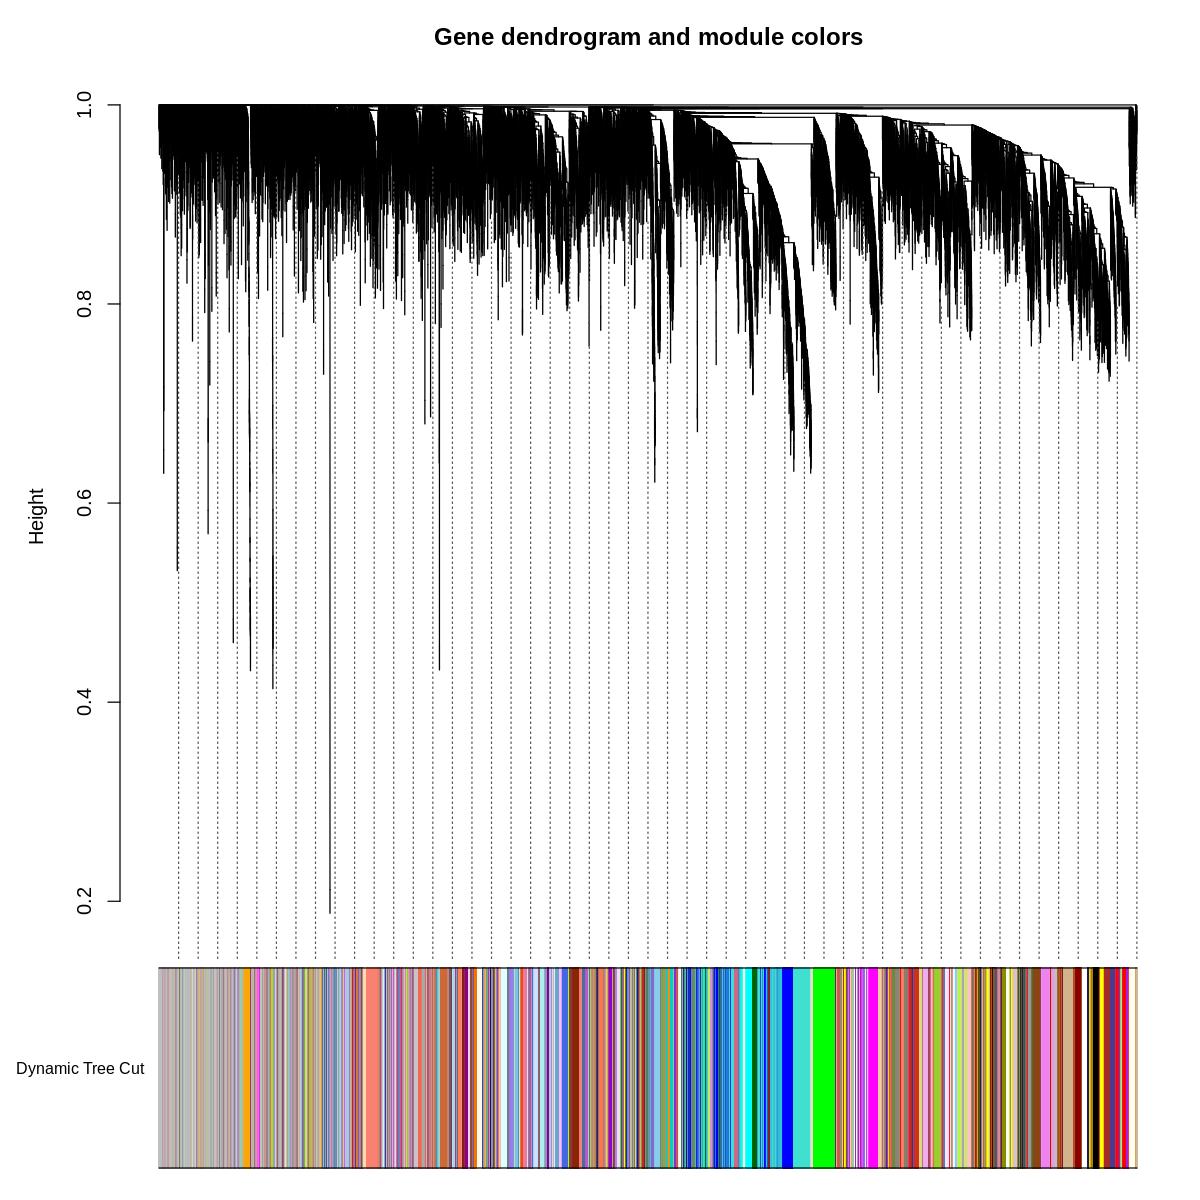

In [65]:
#plot the dendrogram and colors underneath

plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Gene dendrogram and module colors")

## 4. Merge modules based on their module eigengenes 

In [67]:
#merge modules whose expression profiles are very similar
#calculate eigengenes
MEList <- moduleEigengenes(datExpr, colors = dynamicColors)
MEs <- MEList$eigengenes
#calculate dissimilarity of module eigengenes
MEDiss <- 1-bicor(MEs)
#cluster module eigengenes
METree <- hclust(as.dist(MEDiss), method= "average")
MEDissThres = 0.2 ; #0.2 means a correlation of 0.8 

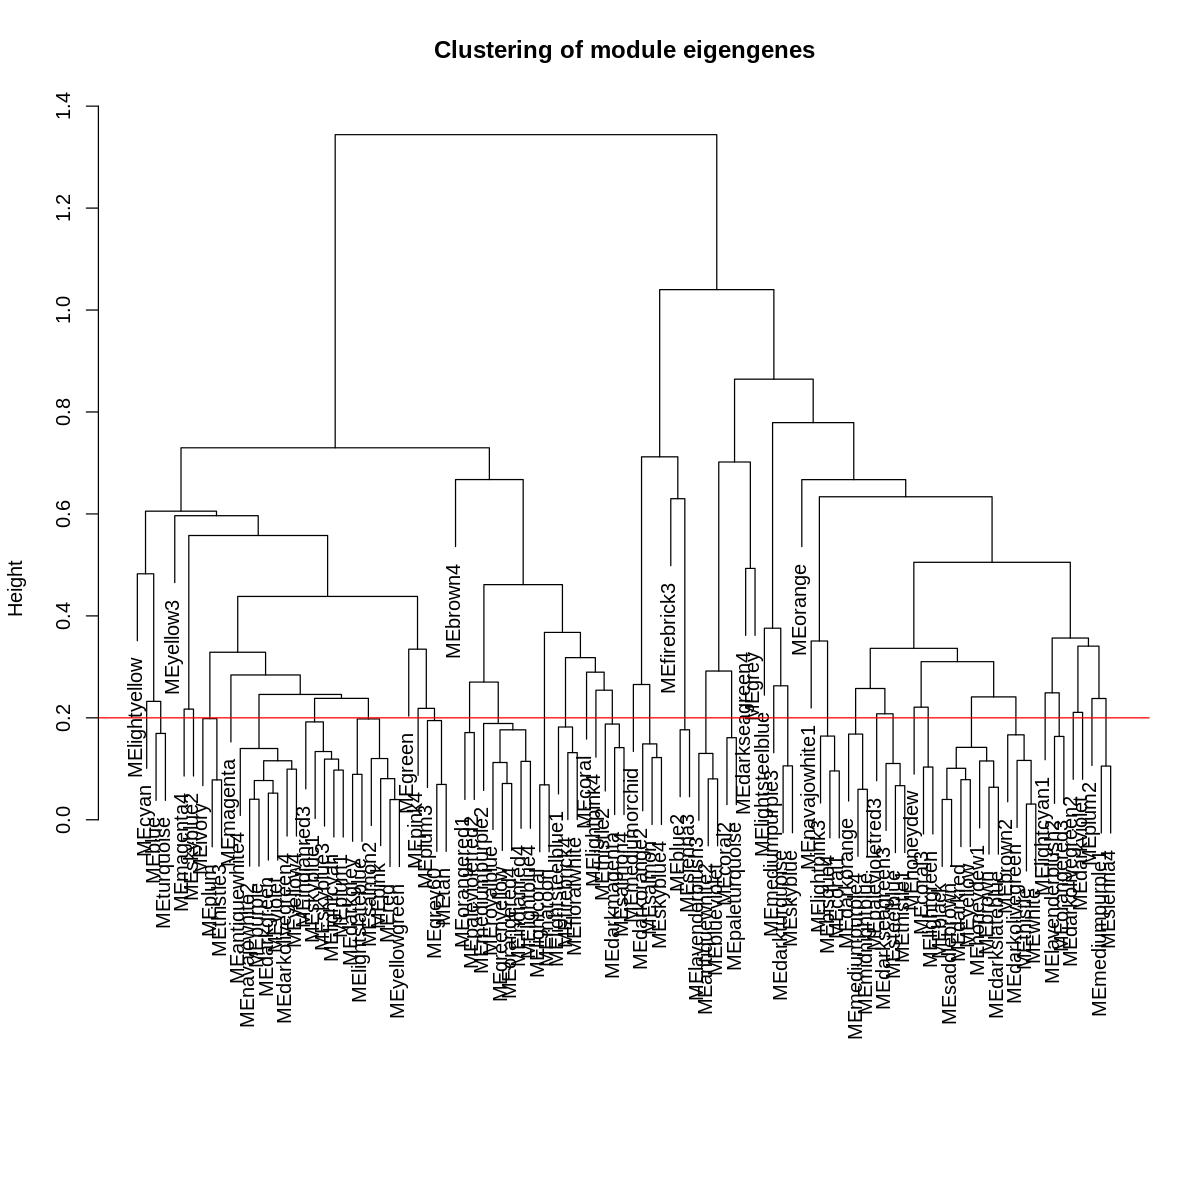

In [68]:
#plot the result
#sizeGrWindow(7, 6)
plot(METree, main = "Clustering of module eigengenes",
     xlab = "", sub = "")

# Plot the cut line into the dendrogram
abline(h=MEDissThres, col = "red")

In [69]:
#call an automatic merging function
merge = mergeCloseModules(datExpr, dynamicColors, cutHeight = MEDissThres, verbose = 3)
#the merged module colors
mergedColors = merge$colors;
#eigengenes of the new merged module 
mergedMEs = merge$newMEs;


 mergeCloseModules: Merging modules whose distance is less than 0.2
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 105 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 45 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 35 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 32 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 31 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 31 module eigengenes in given set.


In [ ]:
plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)


In [71]:
#rename to moduleColors
moduleColors = mergedColors
#construct numerical labels corresponding to the colors
colorOrder = c("grey", standardColors(50));
moduleLabels = match(moduleColors, colorOrder)-1;
MEs = mergedMEs;

In [7]:
MEs

MEyellow3,MElightcyan1,MElightpink3,MEblueviolet,MEdarkviolet,MEdarkolivegreen2,MEsalmon,MEdarkseagreen3,MElightsteelblue,MEorange,⋯,MEcoral2,MEindianred3,MEmagenta4,MEmaroon,MEivory,MElightcyan,MEmediumpurple2,MEcoral,MEfirebrick4,MEgrey
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.09686345,0.15530522,0.12722643,0.05473053,-0.07846640,0.05272496,0.172501658,0.11401628,0.16309234,-0.10345158,⋯,-0.31735819,-0.37948434,-0.31073227,0.009185176,-0.17329005,-0.203123291,-0.04591278,0.02737880,-0.10646317,-0.1217922199
-0.14850585,0.14402303,0.13127425,0.13301247,-0.01384657,0.06477776,0.153843593,0.17490793,0.18730205,-0.11277543,⋯,-0.28449384,-0.51348600,-0.29670900,0.026098837,-0.05777045,-0.231894639,-0.19483000,0.06014672,-0.06177930,-0.0497683748
-0.13488244,-0.03957065,-0.02915445,0.14300499,0.06989972,0.04218765,0.217792489,0.24251436,0.38738280,-0.06482562,⋯,-0.08124515,-0.24111078,-0.20539527,0.117139952,-0.01946197,-0.182040917,-0.21835884,0.07813281,-0.01417545,-0.0028858298
-0.20644226,0.54712681,0.62947752,0.42950631,0.32964201,0.02312833,-0.392991784,0.04445653,-0.32994339,-0.03686350,⋯,-0.02564681,-0.21406359,0.02353983,-0.713857229,-0.26341564,-0.402994175,-0.28868920,-0.16932673,-0.15801020,0.6401229687
0.53528777,0.21882842,0.02482505,0.46331870,0.51423578,-0.08089020,-0.250696054,0.17269725,-0.04943657,-0.12146026,⋯,0.15017440,0.07631291,0.03800188,-0.373651722,-0.31332961,-0.190786032,0.17140652,-0.16974449,-0.12124359,-0.5851687500
-0.12650711,-0.10439680,-0.09074287,0.14309849,0.19481218,0.03603343,0.296741366,0.27749711,0.40422284,0.73690494,⋯,0.06782763,-0.07559550,-0.20504255,0.034882346,-0.08367996,-0.159321282,-0.04577147,0.30087835,-0.04400738,-0.3201308969
0.70511961,0.22261990,0.27901425,0.22531648,0.14430339,-0.11787282,0.001169864,0.20318129,0.14032368,-0.15523251,⋯,0.08187158,-0.03152286,0.07565942,-0.071461530,-0.10105292,-0.189125675,-0.18319787,-0.09035723,-0.01975383,0.1829991025
-0.08077789,0.14800337,0.20444240,0.18988600,0.14919596,-0.06116841,-0.043984987,0.13154710,0.03337100,-0.08294907,⋯,0.09735201,0.04570505,0.10879992,-0.180065643,-0.18571276,-0.168086841,-0.24306618,-0.09106069,-0.08553368,0.0402482368
-0.05992762,-0.28372755,-0.04510630,-0.17594428,-0.36769589,-0.19239942,-0.227645721,-0.50935690,-0.23797027,-0.17026438,⋯,0.44403972,0.29473990,0.43804772,0.212709607,0.50574784,0.453320043,0.11370843,0.08004825,0.48390773,0.2372437912


### 4.1 Pull out the gene ids from each module 

Here, I saved all the modules and thier corresponding genes to module_* and text files. Next, I determined which modules contain the wnt3 gene (Sc4wPfr_399.g28064) and the Jun and Fos genes (Sc4wPfr_119.1.g1450 and Sc4wPfr_677.g23720).

In [72]:
#recheck modules after modules were merged 
table(moduleColors)

#determine which module has wnt3 gene 
which(colnames(datExpr) == "Sc4wPfr_399.g28064")
moduleColors[[9753]] ;#dark green 1507

moduleColors
          blue2      blueviolet           coral          coral2       darkgreen 
           3420            3415              60             446            1507 
darkolivegreen2      darkorange   darkseagreen3   darkseagreen4      darkviolet 
            154             340             305              88             173 
     firebrick3      firebrick4            grey        honeydew      indianred3 
             41             724            1835              61             122 
          ivory       lightcyan      lightcyan1      lightpink3  lightslateblue 
            282            1687             261             258             487 
 lightsteelblue        magenta4          maroon   mediumpurple2   mediumpurple3 
             76              63              94              76             272 
   navajowhite1          orange           pink4          salmon         sienna3 
             64             156              50             262             137 
        yellow3

[1] 9753

[1] "darkgreen"

In [ ]:
#save the colnames of datExpr dataframe as SubGeneNames
SubGeneNames = colnames(datExpr)
#just pull out the gene names for the darkgreen module 
wnt3_darkgreen_module=as.data.frame(SubGeneNames[which(moduleColors=="darkgreen")])
names(wnt3_darkgreen_module)[1] <- "Gene_ID"
#grab the annotated GO terms for each gene from the object GeneGO_table_4 (steps from below)
wnt3_darkgreen_module_annot <- setDT(GeneGO_table_4, key = 'Gene_ID')[J(wnt3_darkgreen_module)]
#write.csv(wnt3_darkgreen_module_annot, file = "wnt3_darkgreen_module_annot_112421.csv")

In [7]:
# Jun and Fos Transript IDs are both found in the same module coral2
#Sc4wPfr_119.1.g1450 - Jun
#Sc4wPfr_677.g23720 - Fos 

which(colnames(datExpr) == "Sc4wPfr_119.1.g1450")
moduleColors[[1539]] 

which(colnames(datExpr) == "Sc4wPfr_677.g23720")
moduleColors[[13861]] 

[1] 1539

[1] "coral2"

[1] 13861

[1] "coral2"

In [ ]:
#coral2
fos_jun_coral2_module=as.data.frame(SubGeneNames[which(moduleColors=="coral2")])
names(fos_jun_coral2_module)[1] <- "Gene_ID"
fos_jun_coral2_module <- setDT(GeneGO_table_4, key = 'Gene_ID')[J(fos_jun_coral2_module)]
write.csv(fos_jun_coral2_module, file = "fos_jun_coral2_module_annot.csv")

In [ ]:
#save all the modules and thier corresponding genes as text files. 
SubGeneNames = colnames(datExpr)
for (color in moduleColors){
  module=SubGeneNames[which(moduleColors==color)]
  module_name = which(moduleColors==color )
  write.table(module, module_name, paste("ALL_module_",color, ".csv",sep=""), sep="\t", row.names=FALSE, col.names=FALSE,quote=FALSE)
}

### 4.2 Determine the network connectivity 


In [17]:
ADJ1=abs(cor(datExpr,use="p"))^18
Alldegrees1=intramodularConnectivity(ADJ1, moduleColors)
head(Alldegrees1)

,kTotal,kWithin,kOut,kDiff
,<dbl>,<dbl>,<dbl>,<dbl>
Sc4wPfr_1.g5776,1.7011187,0.3925020,1.3086167,-0.9161148
Sc4wPfr_1.g5779,0.7406525,0.2677687,0.4728838,-0.2051150
Sc4wPfr_1.g5780,0.5294099,0.1607676,0.3686423,-0.2078747
Sc4wPfr_1.g5781,29.7004980,2.8531368,26.8473611,-23.9942243
Sc4wPfr_1.g5782,54.0871454,16.5175919,37.5695535,-21.0519616
Sc4wPfr_1.g5784,42.2301735,7.9833779,34.2467956,-26.2634177


In [15]:
datME=moduleEigengenes(datExpr, moduleColors)$eigengenes
signif(cor(datME, use="p"), 2)

,MEblue2,MEblueviolet,MEcoral,MEcoral2,MEdarkgreen,MEdarkolivegreen2,MEdarkorange,MEdarkseagreen3,MEdarkseagreen4,MEdarkviolet,⋯,MEmagenta4,MEmaroon,MEmediumpurple2,MEmediumpurple3,MEnavajowhite1,MEorange,MEpink4,MEsalmon,MEsienna3,MEyellow3
MEblue2,1.0000,-0.780,-0.580,-0.42000,0.770,0.640,-0.6300,-0.047,-0.7600,-0.0920,⋯,-0.0046,0.250,-0.035,-0.61000,-0.4000,-0.2200,0.720,0.43000,0.6700,-0.090
MEblueviolet,-0.7800,1.000,0.045,0.12000,-0.890,-0.240,0.6200,0.470,0.3500,0.6700,⋯,-0.1500,-0.700,-0.310,0.31000,0.1300,0.0330,-0.670,-0.28000,-0.2400,0.320
MEcoral,-0.5800,0.045,1.000,0.30000,-0.140,-0.670,0.4900,-0.310,0.5200,-0.5900,⋯,-0.1400,0.490,0.570,0.73000,0.2800,0.5100,-0.130,-0.19000,-0.6300,-0.230
MEcoral2,-0.4200,0.120,0.300,1.00000,0.021,-0.480,-0.0890,-0.430,0.6500,-0.0930,⋯,0.7700,0.130,0.260,0.12000,0.1100,0.3600,-0.510,-0.45000,-0.7300,0.094
MEdarkgreen,0.7700,-0.890,-0.140,0.02100,1.000,0.058,-0.7600,-0.630,-0.2800,-0.5100,⋯,0.3900,0.490,0.520,-0.50000,-0.0620,-0.0950,0.680,-0.05100,0.3500,-0.120
MEdarkolivegreen2,0.6400,-0.240,-0.670,-0.48000,0.058,1.000,-0.1100,0.610,-0.7700,0.3500,⋯,-0.3900,-0.061,-0.690,-0.25000,-0.6700,-0.1300,0.180,0.77000,0.3900,-0.150
MEdarkorange,-0.6300,0.620,0.490,-0.08900,-0.760,-0.110,1.0000,0.520,0.1600,0.2700,⋯,-0.5500,-0.190,-0.200,0.73000,-0.0680,0.5400,-0.430,0.18000,-0.4000,-0.250
MEdarkseagreen3,-0.0470,0.470,-0.310,-0.43000,-0.630,0.610,0.5200,1.000,-0.5500,0.6700,⋯,-0.6600,-0.310,-0.730,0.15000,-0.5800,0.0610,-0.170,0.67000,0.1400,0.190
MEdarkseagreen4,-0.7600,0.350,0.520,0.65000,-0.280,-0.770,0.1600,-0.550,1.0000,-0.2700,⋯,0.4800,-0.092,0.290,0.39000,0.7000,0.1100,-0.600,-0.72000,-0.6700,-0.120
MEdarkviolet,-0.0920,0.670,-0.590,-0.09300,-0.510,0.350,0.2700,0.670,-0.2700,1.0000,⋯,-0.0720,-0.780,-0.560,-0.22000,-0.3100,-0.0036,-0.330,0.07100,0.2500,0.370


In [8]:
sample_names

[1] "Reg_RNA_0hr"  "Reg_RNA_0hr"  "Reg_RNA_2hr"  "Reg_RNA_2hr"  "Reg_RNA_4hr" 
 [6] "Reg_RNA_4hr"  "Reg_RNA_6hr"  "Reg_RNA_6hr"  "Reg_RNA_12hr" "Reg_RNA_12hr"
[11] "Reg_RNA_24hr" "Reg_RNA_24hr" "Reg_RNA_48hr" "Reg_RNA_48hr" "Hypostome"   
[16] "Hypostome"

In [13]:
sample_names_v2

[1] "SRR8644090" "SRR8644091" "SRR8644092" "SRR8644093" "SRR8644094"
 [6] "SRR8644095" "SRR8644096" "SRR8644097" "SRR8644098" "SRR8644099"
[11] "SRR8644100" "SRR8644101" "SRR8644102" "SRR8644103" "SRR8644110"
[16] "SRR8644111"

In [36]:
#options(repr.plot.width=8, repr.plot.height=8)

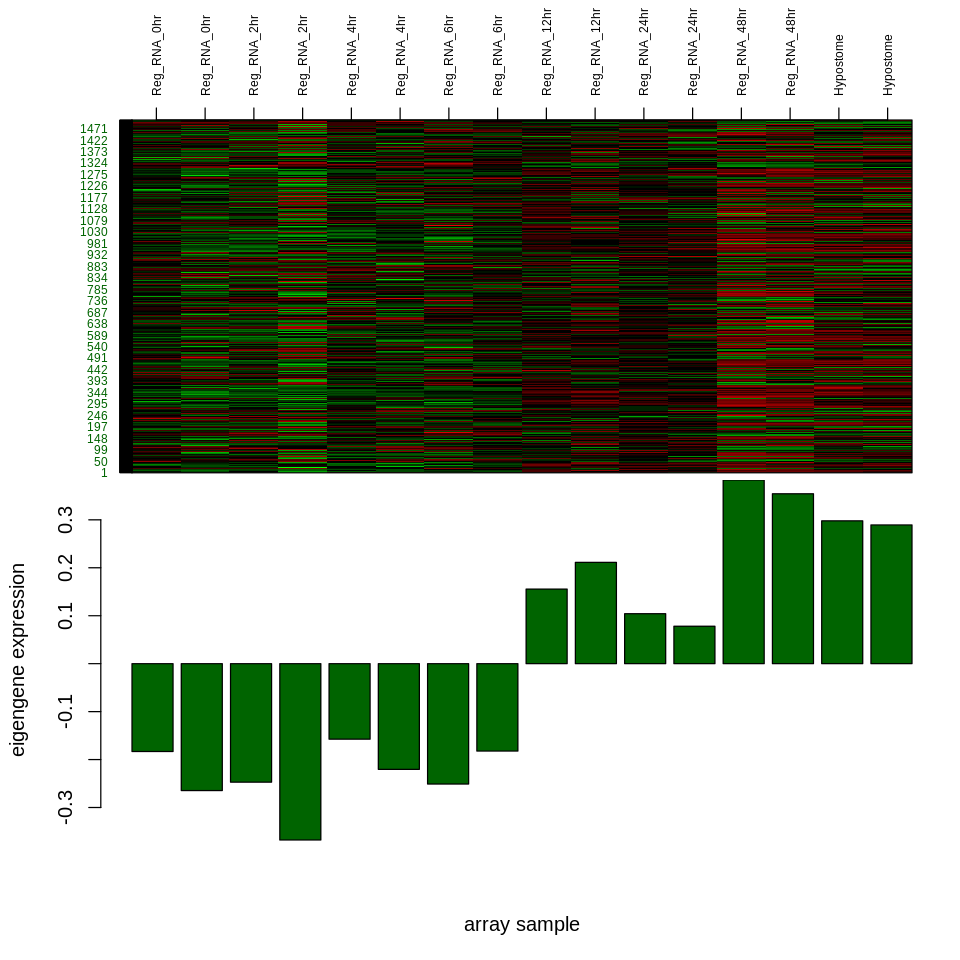

In [37]:

which.module="darkgreen"
ME=datME[, paste("ME",which.module, sep="")]
par(mfrow=c(2,1), mar=c(0.3, 5.5, 5, 2))
plotMat(t(scale(datExpr[,moduleColors==which.module ]) ),
        nrgcols=30,rlabels=T,rcols=which.module,clabels=sample_names,
         cex.main=2)
par(mar=c(5, 4.2, 0, 0.7))
barplot(ME, col=which.module, main="", cex.main=2,
        ylab="eigengene expression",xlab="array sample")


In [4]:
#this chunk of code below is to save the graph as a pdf for publication 
pdf("FIGURES_wnt3_darkgreen_eigengene.pdf")

which.module="darkgreen"
ME=datME[, paste("ME",which.module, sep="")]
par(mfrow=c(2,1), mar=c(0.3, 5.5, 5, 2))
plotMat(t(scale(datExpr[,moduleColors==which.module ]) ),
        nrgcols=30,rlabels=T,rcols=which.module,clabels=sample_names,
         cex.main=2)
par(mar=c(5, 4.2, 0, 0.7))
barplot(ME, col=which.module, main="", cex.main=2,
        ylab="eigengene expression",xlab="array sample")




# Closing the graphical device
dev.off() 

png 
  2

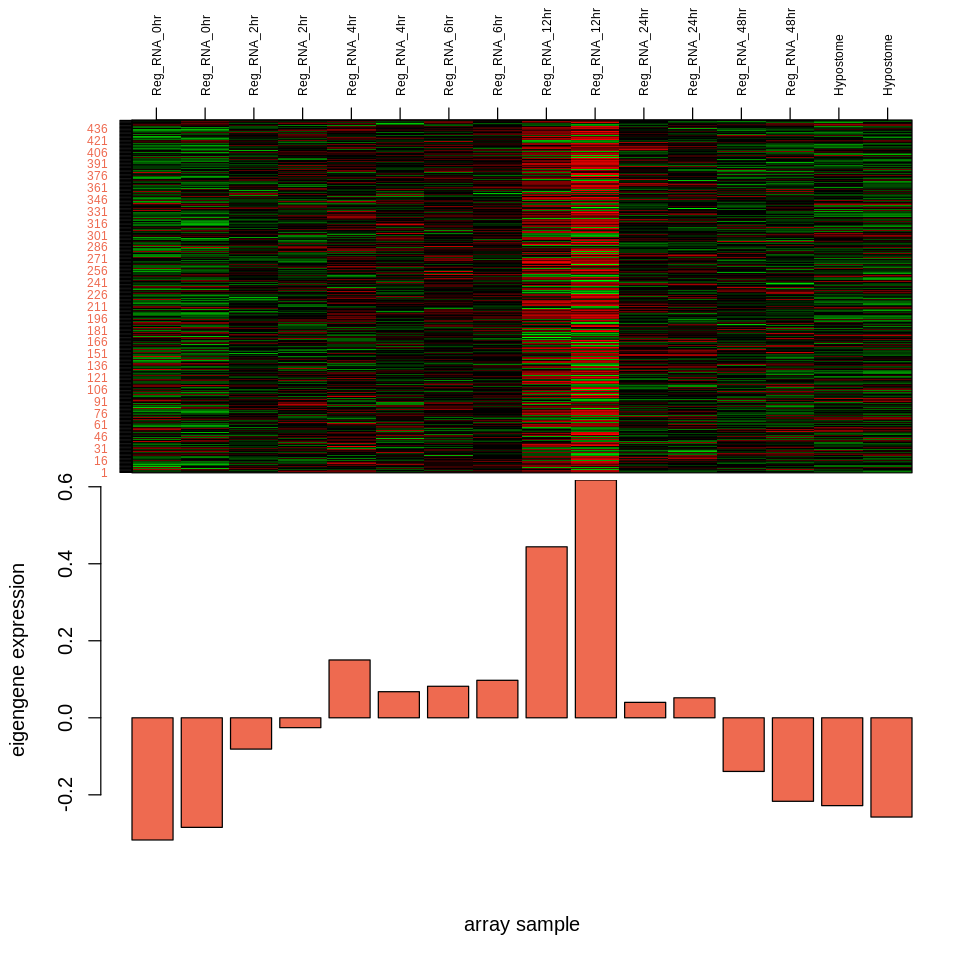

In [38]:

which.module="coral2"
ME=datME[, paste("ME",which.module, sep="")]
par(mfrow=c(2,1), mar=c(0.3, 5.5, 5, 2))
plotMat(t(scale(datExpr[,moduleColors==which.module ]) ),
        nrgcols=30,rlabels=T,rcols=which.module,clabels=sample_names,
         cex.main=2)
par(mar=c(5, 4.2, 0, 0.7))
barplot(ME, col=which.module, main="", cex.main=2,
        ylab="eigengene expression",xlab="array sample")


In [7]:
#this chunk of code below is to save the graph as a pdf for publication 
pdf("FIGURES_jun_fos_coral2_eigengene.pdf")

which.module="coral2"
ME=datME[, paste("ME",which.module, sep="")]
par(mfrow=c(2,1), mar=c(0.3, 5.5, 5, 2))
plotMat(t(scale(datExpr[,moduleColors==which.module ]) ),
        nrgcols=30,rlabels=T,rcols=which.module,clabels=sample_names,
         cex.main=2)
par(mar=c(5, 4.2, 0, 0.7))
barplot(ME, col=which.module, main="", cex.main=2,
        ylab="eigengene expression",xlab="array sample")




# Closing the graphical device
dev.off() 

png 
  2

In [19]:
datKME =signedKME(datExpr, datME, outputColumnName="MM.")
head(datKME)

,MM.blue2,MM.blueviolet,MM.coral,MM.coral2,MM.darkgreen,MM.darkolivegreen2,MM.darkorange,MM.darkseagreen3,MM.darkseagreen4,MM.darkviolet,⋯,MM.magenta4,MM.maroon,MM.mediumpurple2,MM.mediumpurple3,MM.navajowhite1,MM.orange,MM.pink4,MM.salmon,MM.sienna3,MM.yellow3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sc4wPfr_1.g5776,-0.2750700,0.4105593,0.15234137,-0.2033124,-0.5569074,0.23439917,0.58981448,0.6628683,-0.19899702,0.2670927,⋯,-0.6033996,-0.040442116,-0.2754719,0.35734455,-0.46468239,0.17737095,-0.1354311,0.43233126,-0.1974880,0.12466671
Sc4wPfr_1.g5779,-0.4462749,0.4614629,0.01794797,0.2856970,-0.5300994,-0.16260199,0.17262419,0.3686916,0.15742149,0.2852772,⋯,0.1034255,-0.002914036,-0.3078708,0.04382081,-0.06911064,0.04255594,-0.2777784,0.13336148,-0.2810529,0.53246702
Sc4wPfr_1.g5780,-0.4221721,0.2243329,0.04813905,0.3521242,-0.2854745,-0.26208404,-0.07532696,-0.1735903,0.57555620,-0.1123236,⋯,0.3332765,0.007923119,-0.1881521,0.10119766,0.28913841,-0.28283492,-0.3697415,-0.25216193,-0.4431274,-0.03603257
Sc4wPfr_1.g5781,-0.3082147,0.7038150,-0.46536282,-0.2125663,-0.6180410,0.07020468,0.25434531,0.3985817,0.09514295,0.7177286,⋯,-0.0502985,-0.868156409,-0.5471675,-0.18742693,0.27545622,-0.26803781,-0.4106775,-0.19117715,0.2518422,0.19736854
Sc4wPfr_1.g5782,-0.4305630,0.8130034,-0.14856571,-0.2987855,-0.7241216,-0.02965970,0.53887823,0.5918554,-0.04513414,0.7171432,⋯,-0.3761733,-0.737647131,-0.3383151,0.09962446,0.06925501,-0.03068371,-0.3103478,-0.08458953,0.2138081,0.34931545
Sc4wPfr_1.g5784,-0.2101353,0.6840824,-0.46333442,-0.4978124,-0.6243057,0.21379462,0.25602262,0.5800484,-0.14756233,0.6935558,⋯,-0.4022432,-0.813557711,-0.5196824,-0.15647806,0.10390576,-0.45137274,-0.2388063,-0.03898069,0.4255282,0.37191058


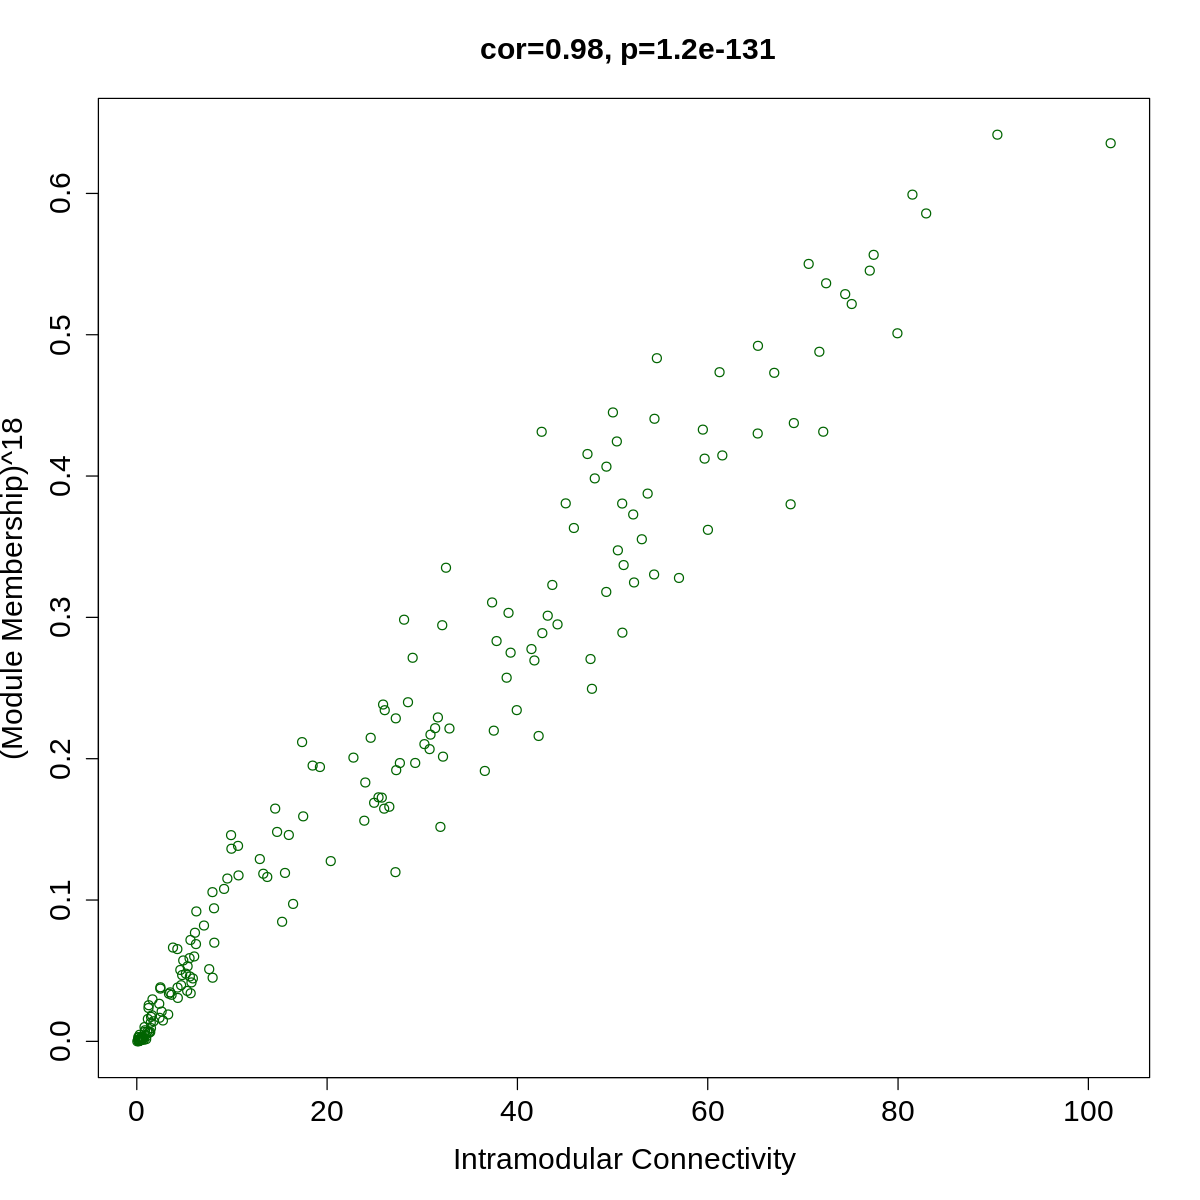

In [20]:
which.color="darkgreen";
restrictGenes=dynamicColors==which.color
verboseScatterplot(Alldegrees1$kWithin[ restrictGenes],
(datKME[restrictGenes, paste("MM.", which.color, sep="")])^10,
col=which.color,
xlab="Intramodular Connectivity",
ylab="(Module Membership)^18")

In [65]:
#now I want to identify the top genes with highest intramodular connectivity and module memebership or also known as hub genes. 

combined_datKME_ADJ1 = merge(datKME, Alldegrees1, by=0)

In [68]:
combined_datKME_ADJ1

Row.names,MM.blue2,MM.blueviolet,MM.coral,MM.coral2,MM.darkgreen,MM.darkolivegreen2,MM.darkorange,MM.darkseagreen3,MM.darkseagreen4,⋯,MM.navajowhite1,MM.orange,MM.pink4,MM.salmon,MM.sienna3,MM.yellow3,kTotal,kWithin,kOut,kDiff
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sc4wPfr_1.g5776,-0.275069993,0.410559291,0.152341366,-0.203312416,-0.55690742,0.23439917,0.58981448,0.66286830,-0.198997021,⋯,-0.46468239,0.177370951,-0.1354311,0.432331263,-0.197487972,0.12466671,1.7011187,0.3925020,1.3086167,-0.91611475
Sc4wPfr_1.g5779,-0.446274873,0.461462895,0.017947968,0.285697034,-0.53009936,-0.16260199,0.17262419,0.36869158,0.157421491,⋯,-0.06911064,0.042555938,-0.2777784,0.133361481,-0.281052877,0.53246702,0.7406525,0.2677687,0.4728838,-0.20511502
Sc4wPfr_1.g5780,-0.422172109,0.224332874,0.048139048,0.352124247,-0.28547448,-0.26208404,-0.07532696,-0.17359034,0.575556196,⋯,0.28913841,-0.282834916,-0.3697415,-0.252161934,-0.443127392,-0.03603257,0.5294099,0.1607676,0.3686423,-0.20787468
Sc4wPfr_1.g5781,-0.308214745,0.703814961,-0.465362825,-0.212566343,-0.61804095,0.07020468,0.25434531,0.39858172,0.095142953,⋯,0.27545622,-0.268037810,-0.4106775,-0.191177154,0.251842185,0.19736854,29.7004980,2.8531368,26.8473611,-23.99422432
Sc4wPfr_1.g5782,-0.430562969,0.813003365,-0.148565706,-0.298785455,-0.72412163,-0.02965970,0.53887823,0.59185541,-0.045134138,⋯,0.06925501,-0.030683709,-0.3103478,-0.084589527,0.213808116,0.34931545,54.0871454,16.5175919,37.5695535,-21.05196156
Sc4wPfr_1.g5784,-0.210135314,0.684082359,-0.463334421,-0.497812379,-0.62430574,0.21379462,0.25602262,0.58004842,-0.147562326,⋯,0.10390576,-0.451372737,-0.2388063,-0.038980688,0.425528161,0.37191058,42.2301735,7.9833779,34.2467956,-26.26341774
Sc4wPfr_1.g5785,0.474887969,-0.399185492,0.008736206,-0.147596445,0.54356516,0.02940227,-0.24330418,-0.11922547,-0.475094781,⋯,-0.38932089,0.107465123,0.7301634,0.141829226,0.433853885,0.28361728,1.9945761,1.0344452,0.9601309,0.07431425
Sc4wPfr_1.g5786,0.166017418,-0.528272753,0.442528278,0.142827335,0.53134341,-0.26029197,-0.08156138,-0.57575207,0.131614748,⋯,0.25555724,0.418304670,0.1112086,-0.210633483,-0.187545066,-0.52413002,2.1717429,0.7919784,1.3797645,-0.58778602
Sc4wPfr_1.g5788,0.722013775,-0.746610340,-0.271960370,-0.142620849,0.81510083,0.25368062,-0.65618631,-0.45742782,-0.311557861,⋯,-0.01065196,-0.170334350,0.3959573,-0.076685822,0.334675276,-0.27645171,31.6768580,14.1205826,17.5562753,-3.43569274


In [66]:
subset_combined_datKME_ADJ1 = dplyr::select(combined_datKME_ADJ1, c("Row.names","MM.darkgreen", "kWithin","kTotal"))

In [4]:
head(subset_combined_datKME_ADJ1)

,Row.names,MM.darkgreen,kWithin,kTotal
,<I<chr>>,<dbl>,<dbl>,<dbl>
1,Sc4wPfr_1.g5776,-0.5569074,0.3925020,1.7011187
2,Sc4wPfr_1.g5779,-0.5300994,0.2677687,0.7406525
3,Sc4wPfr_1.g5780,-0.2854745,0.1607676,0.5294099
4,Sc4wPfr_1.g5781,-0.6180410,2.8531368,29.7004980
5,Sc4wPfr_1.g5782,-0.7241216,16.5175919,54.0871454
6,Sc4wPfr_1.g5784,-0.6243057,7.9833779,42.2301735


In [24]:
#make the transcript ids rownames again
#row.names(subset_combined_datKME_ADJ1) <- subset_combined_datKME_ADJ1$Row.names
#subset_combined_datKME_ADJ1[1] <- NULL

In [73]:
#top 200 genes with high connectivity
top_200_datKME_ADJ1 <-subset_combined_datKME_ADJ1 %>% filter(subset_combined_datKME_ADJ1$MM.darkgreen >= 0.1) %>% arrange(desc(MM.darkgreen, kWithin)) %>% dplyr::select(Row.names,MM.darkgreen,kWithin) %>% head(2000) 

In [3]:
head(top_200_datKME_ADJ1)

,Gene_ID,MM.darkgreen,kWithin
,<I<chr>>,<dbl>,<dbl>
1,Sc4wPfr_384.g24771,0.9892189,118.8003
2,Sc4wPfr_482.g19112,0.9872021,111.2688
3,Sc4wPfr_552.g10517,0.9798553,105.4045
4,Sc4wPfr_242.g27678,0.9785817,103.8711
5,Sc4wPfr_215.1.g29569,0.9782934,112.4946
6,Sc4wPfr_796.g23338,0.9765075,106.6900


In [75]:
#take the top 200 genes and find thier corresponding gene annotations 
names(top_200_datKME_ADJ1)[1] <- 'Gene_ID'
top_200_datKME_ADJ1_annotated <- setDT(GeneGO_table_4, key = 'Gene_ID')[J(top_200_datKME_ADJ1)]


In [76]:
top_200_datKME_ADJ1_annotated

Gene_ID,Description,GO_Names,MM.darkgreen,kWithin
<I<chr>>,<chr>,<chr>,<dbl>,<dbl>
Sc4wPfr_384.g24771,cAMP-dependent_kinase_catalytic_subunit_beta_isoform_X2,F:protein_serine/threonine_kinase_activity;_F:ATP_binding;_P:protein_phosphorylation,0.9892189,118.80029
Sc4wPfr_482.g19112,uncharacterized_LOC100210581,C:membrane,0.9872021,111.26881
Sc4wPfr_552.g10517,Low_choriolytic_enzyme,F:metalloendopeptidase_activity;_P:proteolysis;_F:zinc_ion_binding,0.9798553,105.40446
Sc4wPfr_242.g27678,PREDICTED:_uncharacterized_protein_LOC100202684,NoGOs,0.9785817,103.87108
Sc4wPfr_215.1.g29569,synaptic_vesicle_glyco_2B-like,C:integral_component_of_membrane;_P:transmembrane_transport,0.9782934,112.49459
Sc4wPfr_796.g23338,Cell_cycle_control_50A,C:membrane,0.9765075,106.69000
Sc4wPfr_2949.g24301,partitioning_defective_6_homolog_gamma-like,F:protein_binding;_P:establishment_or_maintenance_of_cell_polarity,0.9749459,95.66878
Sc4wPfr_59.2.g12563,F-actin-capping_subunit_alpha,C:F-actin_capping_protein_complex;_P:barbed-end_actin_filament_capping,0.9747188,105.31296
Sc4wPfr_881.g1671,ly6_PLAUR_domain-containing_1-like,NoGOs,0.9736288,99.68285


In [77]:
#write.csv(top_200_datKME_ADJ1_annotated, file="top_200_datKME_ADJ1_annotated.csv")

In [48]:
#check what genes are in my genes of interest object "check" and in the top 2000 genes 
top_200_datKME_ADJ1_annotated$Gene_ID[!top_200_datKME_ADJ1_annotated$Gene_ID %in% check$names]


 [1] "Sc4wPfr_1298.g6415"   "Sc4wPfr_30.g2616"     "Sc4wPfr_377.g83"     
 [4] "Sc4wPfr_301.g13993"   "Sc4wPfr_82.1.g28970"  "Sc4wPfr_17.g15862"   
 [7] "Sc4wPfr_1336.g8889"   "Sc4wPfr_551.g18566"   "Sc4wPfr_703.g8918"   
[10] "Sc4wPfr_2124.g26588"  "Sc4wPfr_14.g1747"     "Sc4wPfr_372.g28041"  
[13] "Sc4wPfr_182.1.g16269" "Sc4wPfr_381.1.g32303" "Sc4wPfr_42.2.g22132" 
[16] "Sc4wPfr_2695.g8779"  

### 4.2 Add the GO annotations from Trinotate output 

Performed Trinotate on UCSB pod cluster and the output read in the text file GeneGO_table2.txt



In [69]:
#read in the annotation file 
GeneGO_table_2 <- read.table("GeneGO_table_2.txt", header = TRUE)
GeneGO_table_2

Gene_ID,Description,GO_Names
<chr>,<chr>,<chr>
MSTRG.22320.1,NA,P:smoothened_signaling_pathway;_C:membrane;_C:integral_component_of_membrane;_F:palmitoyltransferase_activity;_F:transferase_activity;_P:protein_palmitoylation;_P:positive_regulation_of_protein_targeting_to_mitochondrion
MSTRG.22320.2,NA,P:smoothened_signaling_pathway;_C:membrane;_C:integral_component_of_membrane;_F:palmitoyltransferase_activity;_F:transferase_activity;_P:protein_palmitoylation;_P:positive_regulation_of_protein_targeting_to_mitochondrion
Sc4wPfr_227.g25790.t1,NA,P:protein_methylation;_F:S-adenosylmethionine-dependent_methyltransferase_activity;_F:protein_carboxyl_O-methyltransferase_activity
MSTRG.8438.1,NA,P:protein_methylation;_F:S-adenosylmethionine-dependent_methyltransferase_activity;_F:protein_carboxyl_O-methyltransferase_activity
MSTRG.8439.1,NA,P:protein_methylation;_F:S-adenosylmethionine-dependent_methyltransferase_activity;_F:protein_carboxyl_O-methyltransferase_activity
Sc4wPfr_227.g25787.t1,NA,P:protein_methylation;_F:S-adenosylmethionine-dependent_methyltransferase_activity;_F:enzyme_binding;_P:methylation;_F:protein_carboxyl_O-methyltransferase_activity;_P:regulation_of_response_to_DNA_damage_stimulus
Sc4wPfr_250.g16018.t1,NA,P:nucleic_acid_metabolic_process
MSTRG.14598.1,NA,P:cellular_process;_F:oxidoreductase_activity;_F:ion_binding;_P:oxidation-reduction_process
Sc4wPfr_439.g20881.t1,NA,P:cellular_process;_F:oxidoreductase_activity;_F:ion_binding;_C:intracellular_part;_P:oxidation-reduction_process


In [70]:
#remove the .1, .2, & etc in the text file. 
GeneGO_table_3 <- GeneGO_table_2 %>% separate( Gene_ID, into = c("Gene_ID"), sep=".t(.*)")


Warning message:
“Expected 1 pieces. Additional pieces discarded in 36059 rows [3, 6, 7, 9, 10, 12, 15, 16, 17, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, ...].”


In [71]:
#remove duplicates 
GeneGO_table_4 <- GeneGO_table_3[!duplicated(GeneGO_table_3$Gene_ID), ]

### 4.3 Determine the number of genes of interest in modules

In [81]:
my_genes_df_v1$combined[my_genes_df_v1$combined %in% wnt3_darkgreen_module_annot$Gene_ID]



[1] "Sc4wPfr_654.g18227"   "Sc4wPfr_17.g15881"    "Sc4wPfr_624.g29781"  
 [4] "Sc4wPfr_305.g4616"    "Sc4wPfr_691.g31399"   "Sc4wPfr_224.1.g33422"
 [7] "Sc4wPfr_6.g19151"     "Sc4wPfr_399.g28064"   "Sc4wPfr_287.2.g28262"
[10] "Sc4wPfr_1214.g29750"  "Sc4wPfr_440.g6790"    "Sc4wPfr_68.g2322"    
[13] "Sc4wPfr_224.1.g33373" "Sc4wPfr_6.g19151"

## 5. Relate modules to regeneration and hypostome timepoints

In [76]:
#read in the excel spreadheet on traits
hydra_traits <- read_excel("hydra_traits.xlsx")

In [77]:
hydra_traits

Sample_Name,Timepoints,Hypostome,Reg_RNA_0hr,Reg_RNA_2hr,Reg_RNA_4hr,Reg_RNA_6hr,Reg_RNA_12hr,Reg_RNA_24hr,Reg_RNA_48hr
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SRR8644090,Reg_RNA_0hr,0,1,0,0,0,0,0,0
SRR8644091,Reg_RNA_0hr,0,1,0,0,0,0,0,0
SRR8644092,Reg_RNA_2hr,0,0,1,0,0,0,0,0
SRR8644093,Reg_RNA_2hr,0,0,1,0,0,0,0,0
SRR8644094,Reg_RNA_4hr,0,0,0,1,0,0,0,0
SRR8644095,Reg_RNA_4hr,0,0,0,1,0,0,0,0
SRR8644096,Reg_RNA_6hr,0,0,0,0,1,0,0,0
SRR8644097,Reg_RNA_6hr,0,0,0,0,1,0,0,0
SRR8644098,Reg_RNA_12hr,0,0,0,0,0,1,0,0


In [12]:

sample_names_v2 <- hydra_traits$Sample_Name

In [ ]:
sample_trial_names <- hydra_traits

In [109]:
#ran into an issue where the trait list as to be numberic 
sample_names_numeric <- c("0", "0", "2", "2", "4", "4", "6", 
                  "6", "12", "12", "24", "24", "48", "48", 
                  "0.05", "0.05")

hydra_traits$sample_names_numeric <- sample_names_numeric


In [7]:
sample_names

[1] "Reg_RNA_0hr"  "Reg_RNA_0hr"  "Reg_RNA_2hr"  "Reg_RNA_2hr"  "Reg_RNA_4hr" 
 [6] "Reg_RNA_4hr"  "Reg_RNA_6hr"  "Reg_RNA_6hr"  "Reg_RNA_12hr" "Reg_RNA_12hr"
[11] "Reg_RNA_24hr" "Reg_RNA_24hr" "Reg_RNA_48hr" "Reg_RNA_48hr" "Hypostome"   
[16] "Hypostome"

In [111]:

HydraSamples =as.character(sample_names)
traitRows =match(HydraSamples,hydra_traits$Timepoints)


In [112]:
traitRows

[1]  1  1  3  3  5  5  7  7  9  9 11 11 13 13 15 15

In [113]:
datTraits =hydra_traits[traitRows, -1]

In [114]:
datTraits

Timepoints,Hypostome,Reg_RNA_0hr,Reg_RNA_2hr,Reg_RNA_4hr,Reg_RNA_6hr,Reg_RNA_12hr,Reg_RNA_24hr,Reg_RNA_48hr,sample_names_numeric
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Reg_RNA_0hr,0,1,0,0,0,0,0,0,0
Reg_RNA_0hr,0,1,0,0,0,0,0,0,0
Reg_RNA_2hr,0,0,1,0,0,0,0,0,2
Reg_RNA_2hr,0,0,1,0,0,0,0,0,2
Reg_RNA_4hr,0,0,0,1,0,0,0,0,4
Reg_RNA_4hr,0,0,0,1,0,0,0,0,4
Reg_RNA_6hr,0,0,0,0,1,0,0,0,6
Reg_RNA_6hr,0,0,0,0,1,0,0,0,6
Reg_RNA_12hr,0,0,0,0,0,1,0,0,12


In [117]:
rownames(datTraits)=hydra_traits$Sample_Name

Warning message:
“Setting row names on a tibble is deprecated.”


In [119]:
datTraits$Timepoints <- NULL

In [128]:
datTraits$sample_names_numeric <- NULL

In [129]:
rownames(datTraits)=hydra_traits$Sample_Name

Warning message:
“Setting row names on a tibble is deprecated.”


Warning message:
“Unknown or uninitialised column: `sample_names_numeric`.”


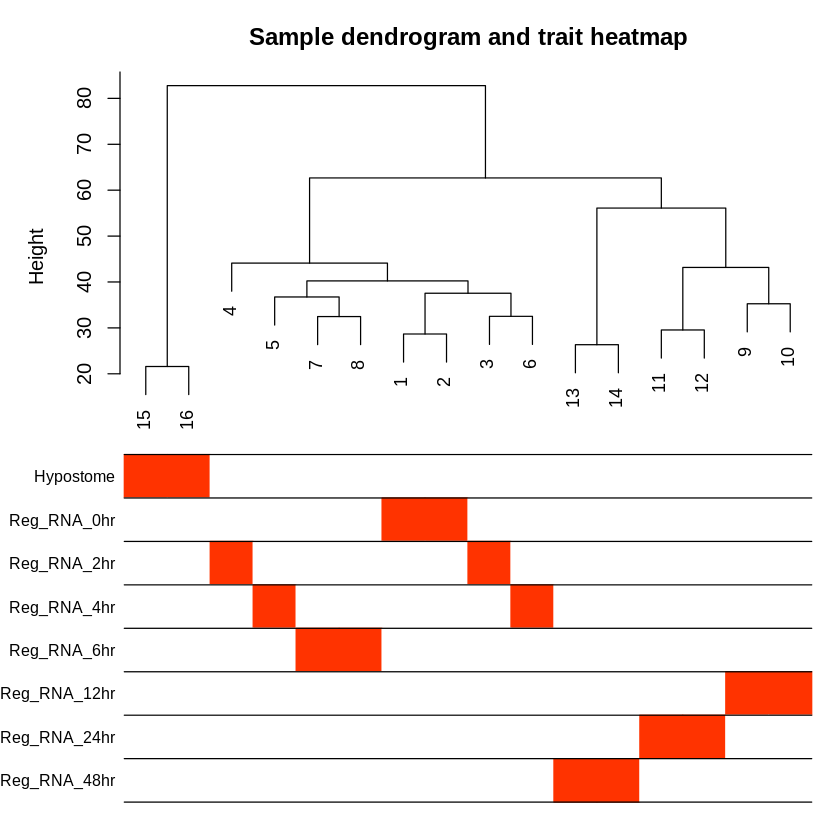

In [131]:
f <-as.numeric(datTraits$sample_names_numeric)
# Re-cluster samples
sampleTree2 = hclust(dist(datExpr), method = "average")
# Convert traits to a color representation: white means low, red means high, grey means missing entry
traitColors = numbers2colors(datTraits, signed = FALSE);
# Plot the sample dendrogram and the colors underneath.
plotDendroAndColors(sampleTree2, traitColors,
                    groupLabels = names(datTraits),
                    main = "Sample dendrogram and trait heatmap")



In [125]:
# define numbers of genes and samples
nGenes = ncol(datExpr);
nSamples = nrow(datExpr);
# recalculate MEs with color labels
MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)



In [132]:
names(MEs)
moduleTraitCor = cor(MEs, datTraits, use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);


[1] "MEyellow3"         "MElightcyan1"      "MElightpink3"     
 [4] "MEblueviolet"      "MEdarkviolet"      "MEdarkolivegreen2"
 [7] "MEsalmon"          "MEdarkseagreen3"   "MElightsteelblue" 
[10] "MEorange"          "MEmediumpurple3"   "MEdarkorange"     
[13] "MEhoneydew"        "MEfirebrick3"      "MEdarkgreen"      
[16] "MElightslateblue"  "MEsienna3"         "MEblue2"          
[19] "MEpink4"           "MEdarkseagreen4"   "MEnavajowhite1"   
[22] "MEcoral2"          "MEindianred3"      "MEmagenta4"       
[25] "MEmaroon"          "MEivory"           "MElightcyan"      
[28] "MEmediumpurple2"   "MEcoral"           "MEfirebrick4"     
[31] "MEgrey"

In [134]:
#view the graph
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
                   signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)


In [35]:
moduleTraitCor

,Hypostome,Reg_RNA_0hr,Reg_RNA_2hr,Reg_RNA_4hr,Reg_RNA_6hr,Reg_RNA_12hr,Reg_RNA_24hr,Reg_RNA_48hr
MEyellow3,-0.05178606,-0.18548176,-0.25801722,0.3090091360,0.47195798,-0.14297333,-1.639219e-01,0.02121314
MElightcyan1,0.08318969,0.22627088,0.38367639,0.0865021743,0.28016486,-0.48018706,-5.932287e-01,0.01361181
MElightpink3,-0.50487360,0.19540815,0.45380159,-0.0498291901,0.36545888,-0.21568525,-3.939264e-01,0.14964583
MEblueviolet,-0.52750718,0.14192037,0.43277786,0.4584083114,0.31386358,-0.22409759,-2.380481e-01,-0.35731725
MEdarkviolet,0.18745303,-0.06978205,0.30202516,0.5359898736,0.22186466,-0.31702105,-5.788269e-01,-0.28170273
MEdarkolivegreen2,0.90242338,0.08882371,0.04937424,-0.0339085292,-0.13534245,-0.30483814,-1.575461e-01,-0.40898616
MEsalmon,0.61027021,0.24669382,-0.13243822,0.0348069841,-0.03236519,-0.33456760,4.234525e-02,-0.43474526
MEdarkseagreen3,0.29406633,0.21840618,0.21692960,0.3403149470,0.25303088,-0.62517579,-1.360140e-01,-0.56155816
MElightsteelblue,-0.10606213,0.26487326,0.04342011,0.2681932131,0.13130084,-0.27788875,2.933751e-01,-0.61721162
MEorange,-0.20005447,-0.16345226,-0.07686975,0.4652324480,-0.18004835,0.16895822,1.393507e-01,-0.15311651


Warning message in plot.window(...):
“"colv" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"colv" is not a graphical parameter”
Warning message in title(...):
“"colv" is not a graphical parameter”


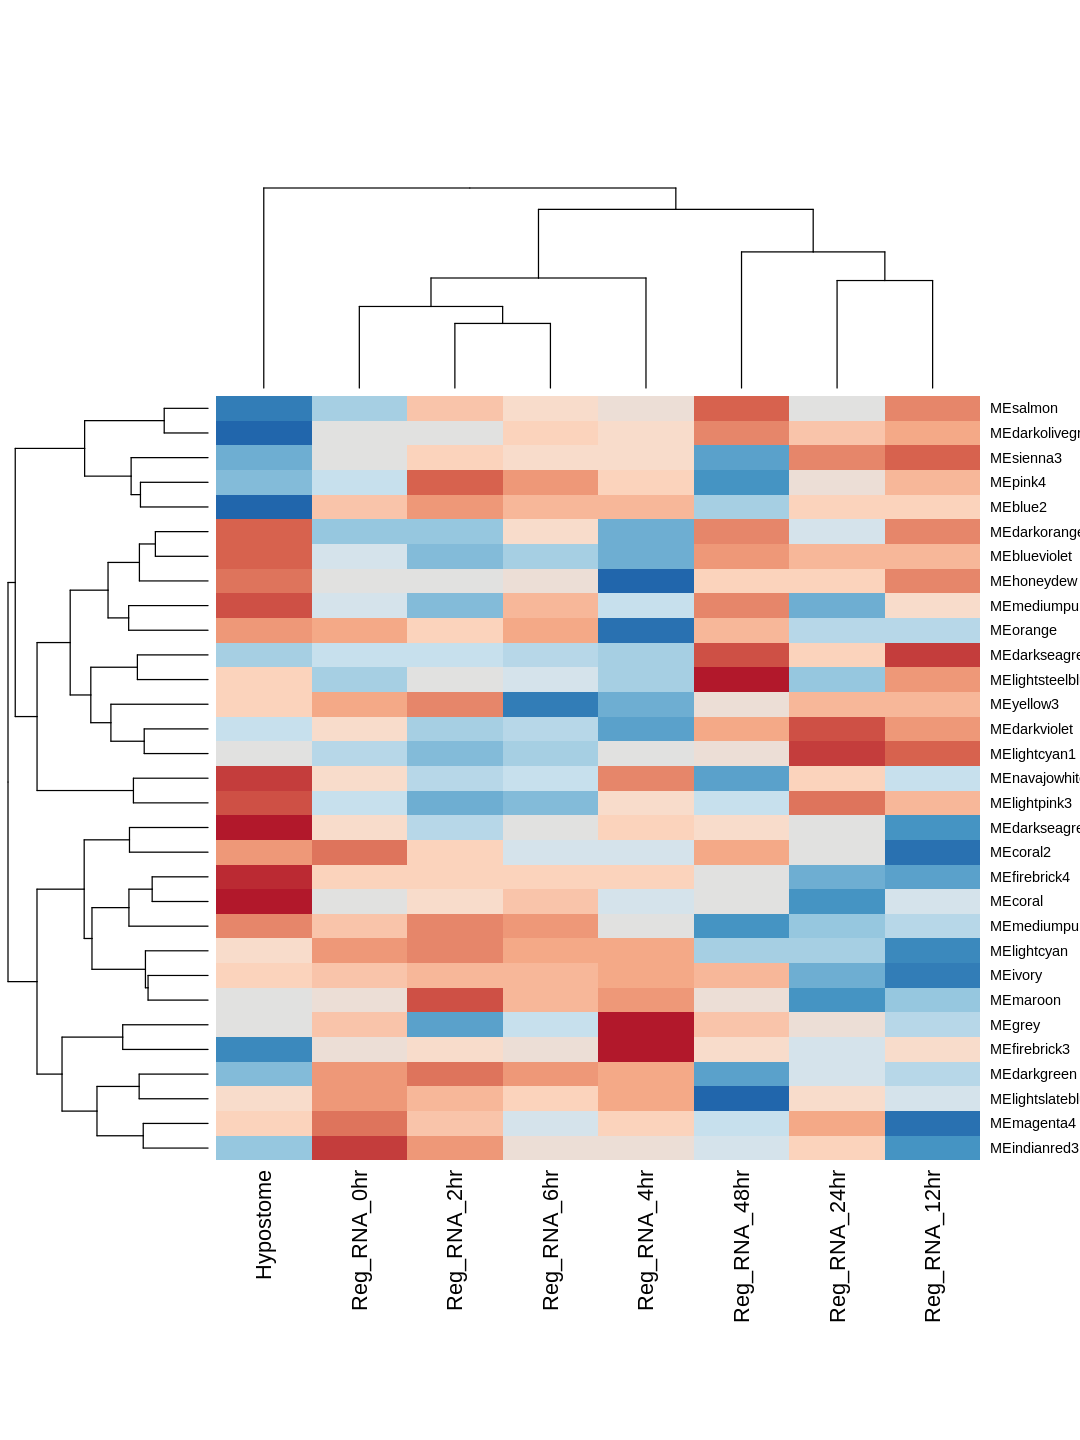

In [65]:
#make the heatmap 
heatmap(moduleTraitCor, colv=NAs,
        col= colorRampPalette(brewer.pal(8, "RdBu"))(28))


In [68]:
# Opening the graphical device
# JPEG device
#pdf("Figure_021621_module_trait_justPvalues_v3.pdf" , width = 8, height = 12)


par(mar = c(20, 12, 6, 3) )
# Display the correlation values within a heatmap plot
labeledHeatmap(moduleTraitCor,
               xLabels = names(datTraits),
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = signif(moduleTraitPvalue, 1),
               setStdMargins = FALSE,
               cex.text = 0.5,
               textAdj = c(0.5, 0.5),
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))

# Closing the graphical device
#dev.off() 


png 
  2

## 6. GO enrichment modules with topGO

In [7]:
#import the trinotate go sheet 
geneID2GO <- readMappings(file ="go_annotations.txt")
#geneNames <- names(geneID2GO)

In [8]:
head(geneID2GO)

$Sc4wPfr_1.g5785.
 [1] "GO:0000166" "GO:0001654" "GO:0001882" "GO:0001883" "GO:0003674"
 [6] "GO:0005488" "GO:0005525" "GO:0005575" "GO:0006810" "GO:0006996"
[11] "GO:0007029" "GO:0007165" "GO:0007264" "GO:0007420" "GO:0007423"
[16] "GO:0008104" "GO:0008150" "GO:0009987" "GO:0015031" "GO:0015833"
[21] "GO:0016043" "GO:0017076" "GO:0019001" "GO:0019003" "GO:0031982"
[26] "GO:0031984" "GO:0032502" "GO:0032549" "GO:0032550" "GO:0032553"
[31] "GO:0032555" "GO:0032561" "GO:0033036" "GO:0034389" "GO:0035556"
[36] "GO:0035639" "GO:0036094" "GO:0042886" "GO:0043167" "GO:0043168"
[41] "GO:0043226" "GO:0043227" "GO:0043230" "GO:0044421" "GO:0044422"
[46] "GO:0044424" "GO:0044432" "GO:0044444" "GO:0044446" "GO:0044464"
[51] "GO:0044699" "GO:0044767" "GO:0045184" "GO:0048513" "GO:0048856"
[56] "GO:0050789" "GO:0050794" "GO:0051179" "GO:0051234" "GO:0065007"
[61] "GO:0070062" "GO:0071702" "GO:0071705" "GO:0071782" "GO:0071786"
[66] "GO:0071840" "GO:0097159" "GO:0097367" "GO:0098827" "GO:1901265"
[71] "GO:1901363" "GO:1903561"

$Sc4wPfr_1.g5786.
  [1] "GO:0000139" "GO:0002063" "GO:0003002" "GO:0003674" "GO:0003824"
  [6] "GO:0005488" "GO:0005575" "GO:0005576" "GO:0006022" "GO:0006023"
 [11] "GO:0006024" "GO:0006082" "GO:0006790" "GO:0006807" "GO:0007389"
 [16] "GO:0008150" "GO:0008152" "GO:0008194" "GO:0008376" "GO:0008589"
 [21] "GO:0009058" "GO:0009059" "GO:0009605" "GO:0009653" "GO:0009887"
 [26] "GO:0009954" "GO:0009966" "GO:0009967" "GO:0009987" "GO:0009991"
 [31] "GO:0010646" "GO:0010647" "GO:0015020" "GO:0016020" "GO:0016021"
 [36] "GO:0016740" "GO:0016757" "GO:0016758" "GO:0023051" "GO:0023056"
 [41] "GO:0030203" "GO:0030204" "GO:0030206" "GO:0030278" "GO:0030279"
 [46] "GO:0031090" "GO:0031224" "GO:0031667" "GO:0032501" "GO:0032502"
 [51] "GO:0032580" "GO:0043167" "GO:0043169" "GO:0043170" "GO:0043436"
 [56] "GO:0044237" "GO:0044249" "GO:0044272" "GO:0044281" "GO:0044422"
 [61] "GO:0044424" "GO:0044425" "GO:0044431" "GO:0044444" "GO:0044446"
 [66] "GO:0044464" "GO:0044699" "GO:0044707" "GO:0044710" "GO:0044711"
 [71] "GO:0044763" "GO:0044767" "GO:0045880" "GO:0046872" "GO:0047238"
 [76] "GO:0048468" "GO:0048513" "GO:0048518" "GO:0048519" "GO:0048522"
 [81] "GO:0048583" "GO:0048584" "GO:0048856" "GO:0048869" "GO:0050510"
 [86] "GO:0050789" "GO:0050794" "GO:0050896" "GO:0051216" "GO:0051239"
 [91] "GO:0051241" "GO:0051923" "GO:0060349" "GO:0065007" "GO:0071704"
 [96] "GO:0098588" "GO:1901135" "GO:1901137" "GO:1901564" "GO:1901566"
[101] "GO:1901576" "GO:1903510"

$Sc4wPfr_1.g5788.
  [1] "GO:0000139" "GO:0002063" "GO:0003002" "GO:0003674" "GO:0003824"
  [6] "GO:0005488" "GO:0005575" "GO:0005576" "GO:0006022" "GO:0006023"
 [11] "GO:0006024" "GO:0006082" "GO:0006790" "GO:0006807" "GO:0007389"
 [16] "GO:0008150" "GO:0008152" "GO:0008194" "GO:0008376" "GO:0008589"
 [21] "GO:0009058" "GO:0009059" "GO:0009605" "GO:0009653" "GO:0009887"
 [26] "GO:0009954" "GO:0009966" "GO:0009967" "GO:0009987" "GO:0009991"
 [31] "GO:0010646" "GO:0010647" "GO:0015020" "GO:0016020" "GO:0016021"
 [36] "GO:0016740" "GO:0016757" "GO:0016758" "GO:0023051" "GO:0023056"
 [41] "GO:0030203" "GO:0030204" "GO:0030206" "GO:0030278" "GO:0030279"
 [46] "GO:0031090" "GO:0031224" "GO:0031667" "GO:0032501" "GO:0032502"
 [51] "GO:0032580" "GO:0043167" "GO:0043169" "GO:0043170" "GO:0043436"
 [56] "GO:0044237" "GO:0044249" "GO:0044272" "GO:0044281" "GO:0044422"
 [61] "GO:0044424" "GO:0044425" "GO:0044431" "GO:0044444" "GO:0044446"
 [66] "GO:0044464" "GO:0044699" "GO:0044707" "GO:0044710" "GO:0044711"
 [71] "GO:0044763" "GO:0044767" "GO:0045880" "GO:0046872" "GO:0047238"
 [76] "GO:0048468" "GO:0048513" "GO:0048518" "GO:0048519" "GO:0048522"
 [81] "GO:0048583" "GO:0048584" "GO:0048856" "GO:0048869" "GO:0050510"
 [86] "GO:0050789" "GO:0050794" "GO:0050896" "GO:0051216" "GO:0051239"
 [91] "GO:0051241" "GO:0051923" "GO:0060349" "GO:0065007" "GO:0071704"
 [96] "GO:0098588" "GO:1901135" "GO:1901137" "GO:1901564" "GO:1901566"
[101] "GO:1901576" "GO:1903510"

$Sc4wPfr_1.g5789.
 [1] "GO:0

In [3]:
myInterestingGenes <- as.character(wnt3_darkgreen_module$Gene_ID)

In [4]:
head(myInterestingGenes)

[1] "Sc4wPfr_1.g5776"   "Sc4wPfr_1.g5779"   "Sc4wPfr_1.g5788"  
[4] "Sc4wPfr_10.g18890" "Sc4wPfr_10.g18898" "Sc4wPfr_10.g18910"

In [5]:
head(geneNames)

[1] "MSTRG.100.1"   "MSTRG.100.2"   "MSTRG.1000.1"  "MSTRG.10000.2"
[5] "MSTRG.10004.1" "MSTRG.10007.1"

## 6.1 GO enrichment of Wnt3 module (darkgreen)

In [42]:
geneNames_v2 <- paste0(geneNames, ".")
head(geneNames_v2)

[1] "MSTRG.100.1."   "MSTRG.100.2."   "MSTRG.1000.1."  "MSTRG.10000.2."
[5] "MSTRG.10004.1." "MSTRG.10007.1."

In [6]:
myInterestingGenes_v2 <- paste0(myInterestingGenes, ".")
head(myInterestingGenes_v2)

[1] "Sc4wPfr_1.g5776."   "Sc4wPfr_1.g5779."   "Sc4wPfr_1.g5788."  
[4] "Sc4wPfr_10.g18890." "Sc4wPfr_10.g18898." "Sc4wPfr_10.g18910."

In [7]:
#subset the genesNames by the transcript IDs in my wnt3 darkgreen module 
geneList <- factor(as.integer(geneNames_v2 %in% myInterestingGenes_v2))
names(geneList) <- geneNames_v2
head(geneList)

MSTRG.100.1.   MSTRG.100.2.  MSTRG.1000.1. MSTRG.10000.2. MSTRG.10004.1. 
             0              0              0              0              0 
MSTRG.10007.1. 
             0 
Levels: 0 1

In [8]:
#run the topGO function  
GOdata <- new("topGOdata", ontology = "BP", allGenes = geneList,
                    annot = annFUN.gene2GO, gene2GO = geneID2GO)

results_go <- runTest(GOdata, algorithm="weight01", statistic="fisher")


Building most specific GOs .....

	( 11380 GO terms found. )


Build GO DAG topology ..........

	( 12094 GO terms and 27941 relations. )


Annotating nodes ...............

	( 11636 genes annotated to the GO terms. )


			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 5842 nontrivial nodes
		 parameters: 
			 test statistic: fisher


	 Level 19:	1 nodes to be scored	(0 eliminated genes)


	 Level 18:	1 nodes to be scored	(0 eliminated genes)


	 Level 17:	9 nodes to be scored	(12 eliminated genes)


	 Level 16:	25 nodes to be scored	(13 eliminated genes)


	 Level 15:	50 nodes to be scored	(65 eliminated genes)


	 Level 14:	98 nodes to be scored	(242 eliminated genes)


	 Level 13:	199 nodes to be scored	(506 eliminated genes)


	 Level 12:	306 nodes to be scored	(1188 eliminated genes)


	 Level 11:	461 nodes to be scored	(2203 eliminated genes)


	 Level 10:	640 nodes to be scored	(3409 eliminated genes)


	 Level 9:	803 nodes to be scored	(4874 eliminated genes)


	 Leve

In [9]:
#retrieve the GO enrichment 
goEnrichment_dark_green   <- GenTable(GOdata, Fisher = results_go, orderBy = "Fisher", topNodes =50, numChar = 10000)


In [57]:
#drop enrichments that have a significant value of 5 or less 
goEnrichment_darkgreen_dropped <- goEnrichment_dark_green %>% filter(Significant > 5 )

In [58]:
goEnrichment_darkgreen_dropped

GO.ID,Term,Annotated,Significant,Expected,Fisher
<chr>,<chr>,<int>,<int>,<dbl>,<chr>
GO:0006364,rRNA processing,134,27,10.20,5.1e-05
GO:0051301,cell division,432,51,32.89,0.00042
GO:0031345,negative regulation of cell projection organization,58,14,4.42,0.00043
GO:0045892,"negative regulation of transcription, DNA-templated",394,41,30.00,0.00137
GO:0006826,iron ion transport,20,6,1.52,0.00283
GO:0043408,regulation of MAPK cascade,363,23,27.64,0.00296
GO:0051453,regulation of intracellular pH,72,11,5.48,0.00382
GO:0007091,metaphase/anaphase transition of mitotic cell cycle,49,9,3.73,0.00388
GO:0045165,cell fate commitment,129,20,9.82,0.00495


In [55]:
#retrieve gene ids that are significantly enriched 
myterms =goEnrichment_darkgreen_dropped$GO.ID 
mygenes = genesInTerm(GOdata, myterms)
 
var=c()
for (i in 1:length(myterms))
{
myterm=myterms[i]
mygenesforterm= mygenes[myterm][[1]]
mygenesforterm=paste(mygenesforterm, collapse=',')
var[i]=paste("GOTerm",myterm,"genes-",mygenesforterm)
}
 
#write.table(var,"genetoGOmapping_wnt3_dropped_less5_032322.txt",sep="\t",quote=F)

    

In [ ]:
#subset GO enrichment table to include GO.ID, Term and Fisher and Significant 

goEnrichment_darkgreen_dropped$Fisher <- as.numeric(goEnrichment_darkgreen_dropped$Fisher)
goEnrichment_darkgreen_dropped <- goEnrichment_darkgreen_dropped[goEnrichment_darkgreen_dropped$Fisher < 0.05,]
goEnrichment_darkgreen_dropped <- goEnrichment_darkgreen_dropped[,c("GO.ID","Term","Fisher", "Significant")]
goEnrichment_darkgreen_dropped


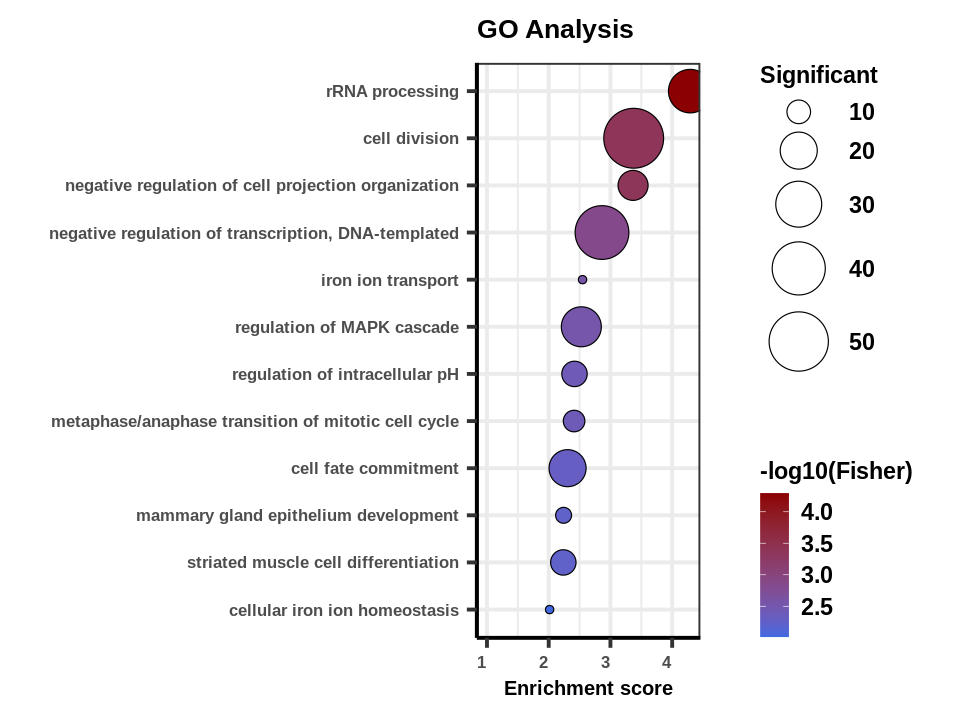

In [76]:
#options(repr.plot.width=6, repr.plot.height=9)

#pdf("Figure_021621_goenrichment_darkgreen.pdf", width = 8, height =3 )

ntop <- 12
ggdata <- goEnrichment_darkgreen_dropped[1:ntop,]
ggdata$Term <- factor(ggdata$Term, levels = rev(ggdata$Term)) # fixes order
ggplot(ggdata,
  aes(x = Term, y = -log10(Fisher), size = Significant, fill = -log10(Fisher))) +

  expand_limits(y = 1) +
  geom_point(shape = 21) +
  #scale_size(range = c(2.5,12.5)) +
  scale_fill_continuous(low = 'royalblue', high = 'red4') +

  xlab('') + ylab('Enrichment score') +
  labs(
    title = 'GO Analysis')+
    scale_size(range = c(2, 16.5))+

  theme_bw(base_size = 24) +
  theme(
    legend.position = 'right',
    legend.background = element_rect(),
    plot.title = element_text(angle = 0, size = 16, face = 'bold', vjust = 1),
    plot.subtitle = element_text(angle = 0, size = 10, face = 'bold', vjust = 1),
    plot.caption = element_text(angle = 0, size = 12, face = 'bold', vjust = 1),

    axis.text.x = element_text(angle = 0, size = 10, face = 'bold', hjust = 1.10),
    axis.text.y = element_text(angle = 0, size = 10, face = 'bold', vjust = 0.5),
    axis.title = element_text(size = 12, face = 'bold'),
    axis.title.x = element_text(size = 12, face = 'bold'),
    axis.title.y = element_text(size = 12, face = 'bold'),
    axis.line = element_line(colour = 'black'),
      

    #Legend
    legend.key = element_blank(), # removes the border
    #legend.key.size = unit(1, "cm"), # Sets overall area/size of the legend
    legend.text = element_text(size = 14, face = "bold"), # Text size
    title = element_text(size = 14, face = "bold")) +

  coord_flip()

#dev.off()

In [79]:
pdf("Figure_032322_goenrichment_darkgreen_v5.pdf", width = 8, height =6 )

ntop <- 12
ggdata <- goEnrichment_darkgreen_dropped[1:ntop,]
ggdata$Term <- factor(ggdata$Term, levels = rev(ggdata$Term)) # fixes order
ggplot(ggdata,
  aes(x = Term, y = -log10(Fisher), size = Significant, fill = -log10(Fisher))) +

  expand_limits(y = 1) +
  geom_point(shape = 21) +
  #scale_size(range = c(2.5,12.5)) +
  scale_fill_continuous(low = 'royalblue', high = 'red4') +

  xlab('') + ylab('Enrichment score') +
  labs(
    title = 'GO Analysis')+
    scale_size(range = c(2, 16.5))+

 
  theme_bw(base_size = 24) +
  theme(
    legend.position = 'right',
    legend.background = element_rect(),
    plot.title = element_text(angle = 0, size = 16, face = 'bold', vjust = 1),
    plot.subtitle = element_text(angle = 0, size = 10, face = 'bold', vjust = 1),
    plot.caption = element_text(angle = 0, size = 12, face = 'bold', vjust = 1),

    axis.text.x = element_text(angle = 0, size = 10, face = 'bold', hjust = 1.10),
    axis.text.y = element_text(angle = 0, size = 10, face = 'bold', vjust = 0.5),
    axis.title = element_text(size = 12, face = 'bold'),
    axis.title.x = element_text(size = 12, face = 'bold'),
    axis.title.y = element_text(size = 12, face = 'bold'),
    axis.line = element_line(colour = 'black'),
      

    #Legend
    legend.key = element_blank(), # removes the border
    #legend.key.size = unit(1, "cm"), # Sets overall area/size of the legend
    legend.text = element_text(size = 14, face = "bold"), # Text size
    title = element_text(size = 14, face = "bold")) +

  coord_flip()

dev.off()

png 
  2

## 6.2 GO enrichment of Jun and Fos module (coral2)

In [4]:
#fos_jun_coral2_module

#save the transcript 
myInterestingGenes_coral2 = as.character(fos_jun_coral2_module$Gene_ID)

myInterestingGenes_v2_coral2 <- paste0(myInterestingGenes_coral2, ".")
head(myInterestingGenes_v2_coral2)



[1] "Sc4wPfr_1007.g33057." "Sc4wPfr_1010.g13514." "Sc4wPfr_1010.g13520."
[4] "Sc4wPfr_1014.g28853." "Sc4wPfr_1021.g3601."  "Sc4wPfr_1036.g374."

In [5]:
#subset the genesNames by the transcript IDs in my red module 
geneList <- factor(as.integer(geneNames_v2 %in% myInterestingGenes_v2_coral2))
names(geneList) <- geneNames_v2
head(geneList)

MSTRG.100.1.   MSTRG.100.2.  MSTRG.1000.1. MSTRG.10000.2. MSTRG.10004.1. 
             0              0              0              0              0 
MSTRG.10007.1. 
             0 
Levels: 0 1

In [16]:
#run the topGO function 
GOdata <- new("topGOdata", ontology = "BP", allGenes = geneList,
                    annot = annFUN.gene2GO, gene2GO = geneID2GO)

results_go <- runTest(GOdata, algorithm="weight01", statistic="fisher")


Building most specific GOs .....

	( 11380 GO terms found. )


Build GO DAG topology ..........

	( 12094 GO terms and 27941 relations. )


Annotating nodes ...............

	( 11636 genes annotated to the GO terms. )


			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 3948 nontrivial nodes
		 parameters: 
			 test statistic: fisher


	 Level 17:	2 nodes to be scored	(0 eliminated genes)


	 Level 16:	9 nodes to be scored	(0 eliminated genes)


	 Level 15:	28 nodes to be scored	(28 eliminated genes)


	 Level 14:	57 nodes to be scored	(127 eliminated genes)


	 Level 13:	102 nodes to be scored	(327 eliminated genes)


	 Level 12:	147 nodes to be scored	(942 eliminated genes)


	 Level 11:	251 nodes to be scored	(1848 eliminated genes)


	 Level 10:	370 nodes to be scored	(2897 eliminated genes)


	 Level 9:	495 nodes to be scored	(4398 eliminated genes)


	 Level 8:	531 nodes to be scored	(5762 eliminated genes)


	 Level 7:	622 nodes to be scored	(7908 eliminated genes)


	 

In [19]:
#retrieve the GO enrichment 
goEnrichment   <- GenTable(GOdata, Fisher = results_go, orderBy = "Fisher", topNodes = 50, numChar = 10000)


In [29]:
#drop enrichments that have a significant value of 5 or less 
goEnrichment_dropped <- goEnrichment %>% filter(Significant > 5 )

In [31]:
#get genes that are significantly enriched 
myterms =goEnrichment_dropped$GO.ID 
mygenes = genesInTerm(GOdata, myterms)
 
var=c()
for (i in 1:length(myterms))
{
myterm=myterms[i]
mygenesforterm= mygenes[myterm][[1]]
mygenesforterm=paste(mygenesforterm, collapse=',')
var[i]=paste("GOTerm",myterm,"genes-",mygenesforterm)
}
 
write.table(var,"genetoGOmapping_coral2_dropped_less5_032322.txt",sep="\t",quote=F)

    

In [33]:
#lets graph the GO enrichment 
goEnrichment_dropped$Fisher <- as.numeric(goEnrichment_dropped$Fisher)
goEnrichment_dropped <- goEnrichment_dropped[goEnrichment_dropped$Fisher < 0.05,] # filter terms for Fisher p<0.05
goEnrichment_dropped <- goEnrichment_dropped[,c("GO.ID","Term","Fisher", "Significant")]
goEnrichment_dropped



,GO.ID,Term,Fisher,Significant
,<chr>,<chr>,<dbl>,<int>
1,GO:0000122,negative regulation of transcription by RNA polymerase II,0.00013,15
2,GO:0030336,negative regulation of cell migration,0.00073,8
3,GO:0030307,positive regulation of cell growth,0.00137,7
4,GO:0032496,response to lipopolysaccharide,0.00196,10
5,GO:0007173,epidermal growth factor receptor signaling pathway,0.00352,7
6,GO:0008543,fibroblast growth factor receptor signaling pathway,0.00389,7
7,GO:0050792,regulation of viral process,0.00421,7
8,GO:0042127,regulation of cell proliferation,0.00561,25
9,GO:0044344,cellular response to fibroblast growth factor stimulus,0.00739,9


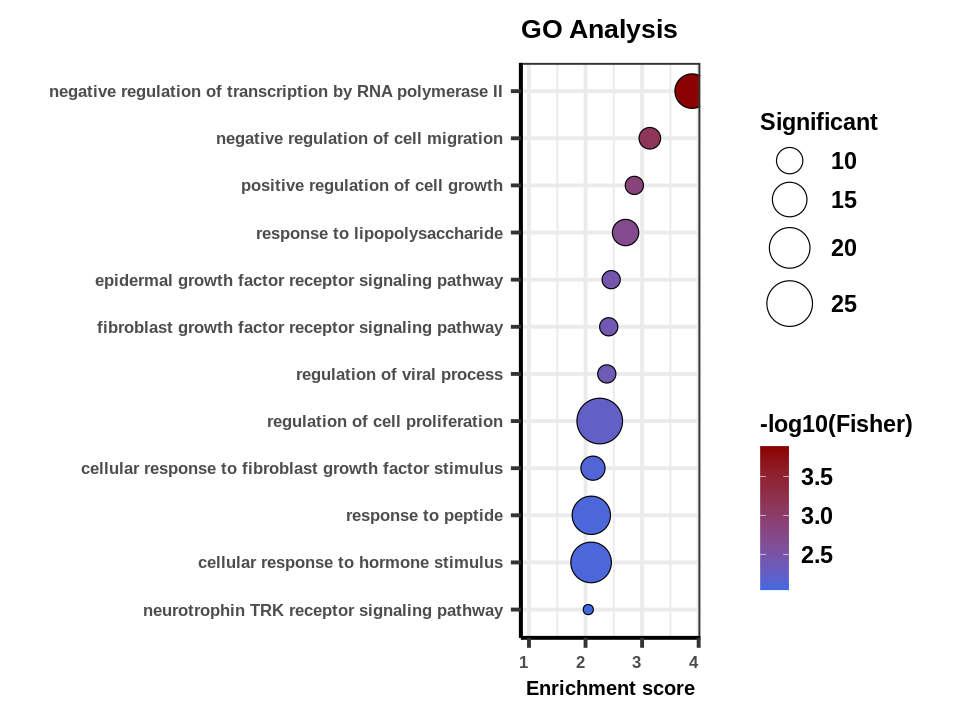

In [36]:
options(repr.plot.width=8, repr.plot.height=6)

#pdf("Figure_031422_goenrichment_coral2_v3_width.pdf", width = 9.4, height =6)


ntop <- 12
ggdata <- goEnrichment_dropped[1:ntop,]
ggdata$Term <- factor(ggdata$Term, levels = rev(ggdata$Term)) # fixes order
ggplot(ggdata,
  aes(x = Term, y = -log10(Fisher), size = Significant, fill = -log10(Fisher))) +

  expand_limits(y = 1) +
  geom_point(shape = 21) +
  scale_size(range = c(2.5,12.5)) +
  scale_fill_continuous(low = 'royalblue', high = 'red4') +

  xlab('') + ylab('Enrichment score') +
  labs(
    title = 'GO Analysis')+
  theme_bw(base_size = 24) +
  theme(
    legend.position = 'right',
    legend.background = element_rect(),
    plot.title = element_text(angle = 0, size = 16, face = 'bold', vjust = 1),
    plot.subtitle = element_text(angle = 0, size = 10, face = 'bold', vjust = 1),
    plot.caption = element_text(angle = 0, size = 12, face = 'bold', vjust = 1),

    axis.text.x = element_text(angle = 0, size = 10, face = 'bold', hjust = 1.10),
    axis.text.y = element_text(angle = 0, size = 10, face = 'bold', vjust = 0.5),
    axis.title = element_text(size = 12, face = 'bold'),
    axis.title.x = element_text(size = 12, face = 'bold'),
    axis.title.y = element_text(size = 12, face = 'bold'),
    axis.line = element_line(colour = 'black'),

    #Legend
    legend.key = element_blank(), # removes the border
    #legend.key.size = unit(1, "cm"), # Sets overall area/size of the legend
    legend.text = element_text(size = 14, face = "bold"), # Text size
    title = element_text(size = 14, face = "bold")) +


  coord_flip()

#dev.off()

In [81]:
pdf("Figure_032322_goenrichment_coral2_v4_width.pdf", width = 8.4, height =6)


ntop <- 12
ggdata <- goEnrichment_dropped[1:ntop,]
ggdata$Term <- factor(ggdata$Term, levels = rev(ggdata$Term)) # fixes order
ggplot(ggdata,
  aes(x = Term, y = -log10(Fisher), size = Significant, fill = -log10(Fisher))) +

  expand_limits(y = 1) +
  geom_point(shape = 21) +
  scale_size(range = c(2.5,12.5)) +
  scale_fill_continuous(low = 'royalblue', high = 'red4') +

  xlab('') + ylab('Enrichment score') +
  labs(
    title = 'GO Analysis')+
  theme_bw(base_size = 24) +
  theme(
    legend.position = 'right',
    legend.background = element_rect(),
    plot.title = element_text(angle = 0, size = 16, face = 'bold', vjust = 1),
    plot.subtitle = element_text(angle = 0, size = 10, face = 'bold', vjust = 1),
    plot.caption = element_text(angle = 0, size = 12, face = 'bold', vjust = 1),

    axis.text.x = element_text(angle = 0, size = 10, face = 'bold', hjust = 1.10),
    axis.text.y = element_text(angle = 0, size = 10, face = 'bold', vjust = 0.5),
    axis.title = element_text(size = 12, face = 'bold'),
    axis.title.x = element_text(size = 12, face = 'bold'),
    axis.title.y = element_text(size = 12, face = 'bold'),
    axis.line = element_line(colour = 'black'),

    #Legend
    legend.key = element_blank(), # removes the border
    #legend.key.size = unit(1, "cm"), # Sets overall area/size of the legend
    legend.text = element_text(size = 14, face = "bold"), # Text size
    title = element_text(size = 14, face = "bold")) +


  coord_flip()

dev.off()

png 
  2

## 7. Network Visualization of Wnt3 module 

In [47]:
# I will recalculate topological overlap with the same power used to make the network
TOM_visnet_power18 = TOMsimilarityFromExpr(datExpr, power = 18)

TOM calculation: adjacency..
..will use 22 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [20]:
# select module
module = "darkgreen" 
# select module probes
genes = colnames(datExpr)
inModule = moduleColors==module 
modProbes = genes[inModule]
modTOM = TOM_visnet_power18[inModule, inModule]
dimnames(modTOM) = list(modProbes, modProbes) 

In [21]:
modTOM

,Sc4wPfr_1.g5776,Sc4wPfr_1.g5779,Sc4wPfr_1.g5788,Sc4wPfr_10.g18890,Sc4wPfr_10.g18898,Sc4wPfr_10.g18910,Sc4wPfr_10.g18928,Sc4wPfr_10.g18929,Sc4wPfr_10.g18937,Sc4wPfr_10.g18990,⋯,Sc4wPfr_975.g7276,Sc4wPfr_977.g21594,Sc4wPfr_977.g21610,Sc4wPfr_98.g2694,Sc4wPfr_98.g2700,Sc4wPfr_98.g2710,Sc4wPfr_98.g2717,Sc4wPfr_983.g32896,Sc4wPfr_999.g13396,Sc4wPfr_999.g13406
Sc4wPfr_1.g5776,1.000000e+00,1.608884e-05,0.0008225604,0.0012036759,7.950505e-04,2.648337e-04,1.249628e-04,1.471756e-03,0.0060669991,6.226718e-03,⋯,0.0044015478,5.836932e-05,0.0026081112,1.982895e-05,0.0027828730,3.434178e-07,0.0008319653,0.0005844210,4.328671e-06,0.0045729228
Sc4wPfr_1.g5779,1.608884e-05,1.000000e+00,0.0092220245,0.0012274295,3.872380e-05,6.233615e-04,1.539682e-06,3.604637e-04,0.0055287791,2.733635e-04,⋯,0.0008788336,5.270363e-06,0.0070117510,4.245518e-07,0.0028817908,3.093447e-06,0.0038690098,0.0001155922,4.567928e-07,0.0012026778
Sc4wPfr_1.g5788,8.225604e-04,9.222024e-03,1.0000000000,0.0059264927,3.448027e-03,6.141086e-03,8.026543e-04,1.228951e-02,0.0380600451,1.073757e-02,⋯,0.0195454815,1.042852e-03,0.0197014135,2.759111e-04,0.0403101557,5.569134e-05,0.0363697614,0.0043426612,4.468305e-05,0.0169049421
Sc4wPfr_10.g18890,1.203676e-03,1.227430e-03,0.0059264927,1.0000000000,2.082372e-03,8.875822e-03,5.053782e-04,6.055606e-03,0.0520788470,2.351427e-03,⋯,0.0136710171,5.000523e-05,0.0215326229,4.525369e-04,0.0606320380,3.713547e-04,0.0164338755,0.0029802023,8.317522e-04,0.0153338711
Sc4wPfr_10.g18898,7.950505e-04,3.872380e-05,0.0034480272,0.0020823724,1.000000e+00,1.354278e-03,4.558356e-05,3.719233e-04,0.0175673506,1.279918e-02,⋯,0.0756431365,5.603242e-04,0.0038316696,2.712045e-05,0.0079486607,4.527069e-04,0.0021584402,0.0113927256,1.942675e-04,0.0079741824
Sc4wPfr_10.g18910,2.648337e-04,6.233615e-04,0.0061410861,0.0088758219,1.354278e-03,1.000000e+00,3.452735e-03,4.825883e-03,0.0256312314,3.042834e-03,⋯,0.0143585821,4.403888e-06,0.0119620209,1.619768e-03,0.1324108101,2.485749e-03,0.0203177671,0.0178848026,3.252410e-03,0.0133709665
Sc4wPfr_10.g18928,1.249628e-04,1.539682e-06,0.0008026543,0.0005053782,4.558356e-05,3.452735e-03,1.000000e+00,3.225891e-03,0.0036832476,5.597931e-03,⋯,0.0030300363,1.226623e-05,0.0005598674,1.058094e-01,0.0100681303,1.506278e-07,0.0054785974,0.0045410312,8.054883e-05,0.0048315865
Sc4wPfr_10.g18929,1.471756e-03,3.604637e-04,0.0122895120,0.0060556056,3.719233e-04,4.825883e-03,3.225891e-03,1.000000e+00,0.0186297593,8.889437e-03,⋯,0.0064694163,6.657960e-04,0.0079476394,8.317600e-04,0.0325342947,7.586213e-06,0.0252820149,0.0030805708,2.122009e-05,0.0160638653
Sc4wPfr_10.g18937,6.066999e-03,5.528779e-03,0.0380600451,0.0520788470,1.756735e-02,2.563123e-02,3.683248e-03,1.862976e-02,1.0000000000,2.108721e-02,⋯,0.0429036563,1.956748e-04,0.0606329386,1.539213e-03,0.0795230404,9.380931e-04,0.0202491437,0.0167714080,2.849600e-03,0.0241795939
Sc4wPfr_10.g18990,6.226718e-03,2.733635e-04,0.0107375720,0.0023514269,1.279918e-02,3.042834e-03,5.597931e-03,8.889437e-03,0.0210872054,1.000000e+00,⋯,0.0443124613,2.354313e-03,0.0065159379,2.418442e-03,0.0269717239,1.340428e-05,0.0221087118,0.0102060634,1.295027e-04,0.0362597711


In [75]:
vis.df = exportNetworkToVisANT(modTOM,
                           file = paste("darkgreen_", module, "top_0.05.txt", sep=""),
                            weighted = TRUE,
                            threshold = 0.09,
                            probeToGene = data.frame(modProbes, modProbes))

In [76]:
vis.df

from,to,direction,method,weight
<chr>,<chr>,<dbl>,<chr>,<dbl>
Sc4wPfr_1.g5776,Sc4wPfr_475.1.g23421,0,M0039,0.12287891
Sc4wPfr_1.g5788,Sc4wPfr_1007.g33054,0,M0039,0.10259453
Sc4wPfr_1.g5788,Sc4wPfr_104.g15038,0,M0039,0.10178402
Sc4wPfr_1.g5788,Sc4wPfr_107.1.g20598,0,M0039,0.11498471
Sc4wPfr_1.g5788,Sc4wPfr_107.1.g20653,0,M0039,0.11405731
Sc4wPfr_1.g5788,Sc4wPfr_1163.g25199,0,M0039,0.09031510
Sc4wPfr_1.g5788,Sc4wPfr_134.g20071,0,M0039,0.09347096
Sc4wPfr_1.g5788,Sc4wPfr_134.g20080,0,M0039,0.09054090
Sc4wPfr_1.g5788,Sc4wPfr_1362.g13669,0,M0039,0.09689176


In [24]:
#subset all edges connected with wnt3 
vis.df.wnt3 <- vis.df[vis.df$from=="Sc4wPfr_399.g28064" | vis.df$to=="Sc4wPfr_399.g28064",]

In [118]:

vis.df.wnt3.filtered <-  filter(vis.df.wnt3, weight > 0.1)


In [119]:
vis.df.wnt3.filtered

from,to,direction,method,weight
<chr>,<chr>,<dbl>,<chr>,<dbl>
Sc4wPfr_1091.g16434,Sc4wPfr_399.g28064,0,M0039,0.1019878
Sc4wPfr_1214.g29750,Sc4wPfr_399.g28064,0,M0039,0.1170357
Sc4wPfr_138.g13929,Sc4wPfr_399.g28064,0,M0039,0.1160475
Sc4wPfr_1515.g11091,Sc4wPfr_399.g28064,0,M0039,0.1242858
Sc4wPfr_166.1.g33693,Sc4wPfr_399.g28064,0,M0039,0.1098926
Sc4wPfr_17.g15897,Sc4wPfr_399.g28064,0,M0039,0.1060051
Sc4wPfr_200.1.g28094,Sc4wPfr_399.g28064,0,M0039,0.1193701
Sc4wPfr_2009.g19366,Sc4wPfr_399.g28064,0,M0039,0.1157165
Sc4wPfr_224.g18119,Sc4wPfr_399.g28064,0,M0039,0.1381862


In [85]:
#write.csv(vis.df.wnt3.filtered, file="vis.df.wnt3.filtered.08.011321.csv")

In [120]:
vis.df.wnt3.filtered.08 <- read_excel("vis.df.wnt3.filtered.1.wnt3.xlsx")

In [121]:
head(vis.df.wnt3.filtered.08)

Gene_ID
<chr>
Sc4wPfr_1091.g16434
Sc4wPfr_1214.g29750
Sc4wPfr_138.g13929
Sc4wPfr_1515.g11091
Sc4wPfr_166.1.g33693
Sc4wPfr_17.g15897


In [122]:
vis.df.wnt3.filtered_network <- as.data.frame(vis.df.wnt3.filtered.08$Gene_ID)

names(vis.df.wnt3.filtered_network)[1]<- "gene"
#head(sig_filtered_upr_redmodule_network_2)

vis.df.wnt3.filtered_network_vector <- as.vector(vis.df.wnt3.filtered_network)
head(vis.df.wnt3.filtered_network_vector)


,gene
,<chr>
1,Sc4wPfr_1091.g16434
2,Sc4wPfr_1214.g29750
3,Sc4wPfr_138.g13929
4,Sc4wPfr_1515.g11091
5,Sc4wPfr_166.1.g33693
6,Sc4wPfr_17.g15897


In [123]:

select = colnames(modTOM) %in% vis.df.wnt3.filtered_network_vector$gene

selectTOM = modTOM[select, select]

vis_handpicked = exportNetworkToVisANT(selectTOM,
                            #file = paste("red_", module, "top_expressed.txt", sep=""),
                            weighted = TRUE,
                            threshold = 0.0,
                            probeToGene = data.frame(vis.df.wnt3.filtered_network$gene, vis.df.wnt3.filtered_network$gene))




In [124]:
head(vis_handpicked)

,from,to,direction,method,weight
,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,Sc4wPfr_1091.g16434,Sc4wPfr_1214.g29750,0,M0039,0.11178418
2,Sc4wPfr_1091.g16434,Sc4wPfr_138.g13929,0,M0039,0.10485779
3,Sc4wPfr_1091.g16434,Sc4wPfr_1515.g11091,0,M0039,0.14054234
4,Sc4wPfr_1091.g16434,Sc4wPfr_166.1.g33693,0,M0039,0.07619889
5,Sc4wPfr_1091.g16434,Sc4wPfr_17.g15897,0,M0039,0.06976927
6,Sc4wPfr_1091.g16434,Sc4wPfr_200.1.g28094,0,M0039,0.09814296


In [117]:


my_genes_df_v1$combined[my_genes_df_v1$combined %in% wnt3_darkgreen_module.vis.df.wnt3.filtered.05_annot$Gene_ID]




[1] "Sc4wPfr_624.g29781"   "Sc4wPfr_305.g4616"    "Sc4wPfr_691.g31399"  
[4] "Sc4wPfr_399.g28064"   "Sc4wPfr_1214.g29750"  "Sc4wPfr_440.g6790"   
[7] "Sc4wPfr_68.g2322"     "Sc4wPfr_224.1.g33373"

In [7]:

wnt3_darkgreen_module.vis.df.wnt3.filtered.05_annot_ADDED <- read_excel("wnt3_darkgreen_module.vis.df.wnt3.filtered.05_annot_ADDED.xlsx")



In [127]:
# create graph from data frames
ggraph_test = graph_from_data_frame(vis_handpicked, directed = FALSE, wnt3_darkgreen_module.vis.df.wnt3.filtered.08_annot)

options(repr.plot.width=10, repr.plot.height=10)

lay = create_layout(ggraph_test, layout = "kk")



In [128]:
ggraph_test

IGRAPH bf4cf80 UNW- 27 351 -- 
+ attr: name (v/c), Description (v/c), GO_Names (v/c), direction (e/n),
| method (e/c), weight (e/n)
+ edges from bf4cf80 (vertex names):
 [1] Sc4wPfr_1091.g16434--Sc4wPfr_1214.g29750 
 [2] Sc4wPfr_1091.g16434--Sc4wPfr_138.g13929  
 [3] Sc4wPfr_1091.g16434--Sc4wPfr_1515.g11091 
 [4] Sc4wPfr_1091.g16434--Sc4wPfr_166.1.g33693
 [5] Sc4wPfr_1091.g16434--Sc4wPfr_17.g15897   
 [6] Sc4wPfr_1091.g16434--Sc4wPfr_200.1.g28094
 [7] Sc4wPfr_1091.g16434--Sc4wPfr_2009.g19366 
+ ... omitted several edges

In [129]:
lay

x,y,name,Description,GO_Names,.ggraph.orig_index,circular,.ggraph.index
<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<lgl>,<int>
-0.5006425,1.1496251,Sc4wPfr_1091.g16434,E3_ubiquitin-_ligase_PDZRN3,F:protein_binding,1,FALSE,1
-0.2564378,-2.2559886,Sc4wPfr_1214.g29750,Wnt-2b,F:receptor_binding;_C:extracellular_region;_P:multicellular_organism_development;_P:Wnt_signaling_pathway,2,FALSE,2
1.6000927,1.1406711,Sc4wPfr_138.g13929,cytosolic_purine_5_-nucleotidase_isoform_X1,F:calcium_ion_binding,3,FALSE,3
0.7919075,0.5989612,Sc4wPfr_1515.g11091,tribbles_homolog_2,F:protein_kinase_activity;_F:ATP_binding;_P:protein_phosphorylation,4,FALSE,4
-1.7372465,-0.3660616,Sc4wPfr_166.1.g33693,bactericidal_permeability-increasing_-like,F:lipopolysaccharide_binding;_P:immune_response;_P:defense_response_to_Gram-negative_bacterium,5,FALSE,5
0.3490587,-0.2649658,Sc4wPfr_17.g15897,ras-specific_guanine_nucleotide-releasing_factor_1,F:Rho_guanyl-nucleotide_exchange_factor_activity;_P:regulation_of_Rho_protein_signal_transduction,6,FALSE,6
-2.8139975,0.9533990,Sc4wPfr_200.1.g28094,LRR_and_PYD_domains-containing_3-like,NoGOs,7,FALSE,7
0.3626493,2.1937256,Sc4wPfr_2009.g19366,"1-phosphatidylinositol_4,5-bisphosphate_phosphodiesterase_delta-4-like",P:lipid_metabolic_process;_F:phosphoric_diester_hydrolase_activity,8,FALSE,8
-2.7632331,-1.2379536,Sc4wPfr_224.g18119,Liprin-beta-,F:protein_binding,9,FALSE,9


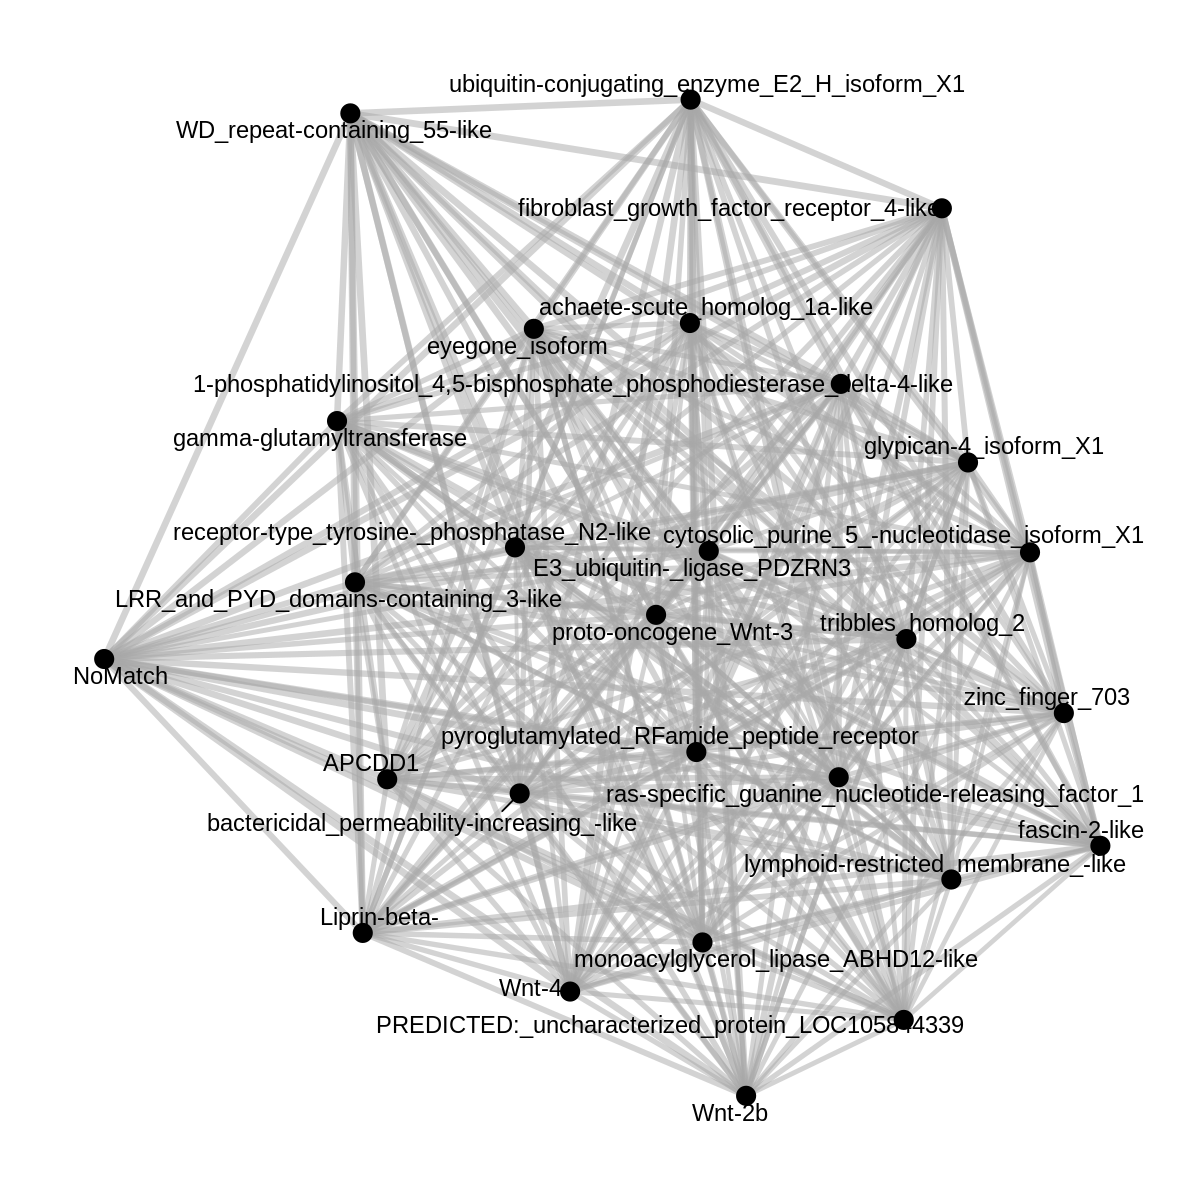

In [135]:
ggraph(lay)+
geom_edge_link(aes(edge_width = weight), edge_colour = "grey66", alpha=0.5)+
theme(legend.position = "none")+
scale_edge_width(range = c(1, 2))+
guides(edge_width="none")+
  geom_node_text(aes(label = Description), size=5, repel=TRUE) +
geom_node_point(size=5)+
#geom_node_point(aes(color=Category), size=6)+
#geom_node_text(aes(label = Gene_name), size=5, repel=TRUE)+
  #geom_node_text(aes(filter = size >= 26, label = name),family="serif")+
  #scale_fill_manual(values = got_palette)+
  #scale_edge_width(range = c(0.2,3))+
  #scale_size(range = c(1,6))+
  theme_graph()
  



In [18]:
#save.image(file="update_021621.RData")

In [3]:
#load("update_021621.RData")

In [82]:
#save.image(file="update_032322.RData")

In [2]:
#load("update_032322.RData")